In [3]:
import numpy as np
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from matplotlib import pyplot as plt
import pandas as pd
import os

## polyfit() function using sklearn.linear_model.RANSACRegressor ##

The polyfit function takes a csv file with equal column sizes as input<br>
Inputs:<ol>
    <li>CSV file name,</li>
    <li>polynomial order (to fit with), </li>
    <li>maxdistance (the maximum deviation from the predicted line allowed for a data point to be considered an outlier)</li></ol>
Returns:
    the x and y columns of the fitted RANSAC line


In [111]:
def polyfit(data, order, maxdistance, disable_linear = True):
    #loading and extracting columns of data for x and y
    df = pd.read_csv(data, header = None)
    dfx = df[0].values
    dfy = df[1].values
    
    #if variance of x is low, swap x and y, to prevent a vertical line
    if np.var(dfx)<np.var(dfy):
        tmp = dfx
        dfx = dfy
        dfy = tmp
    
    x = np.reshape(dfx, (len(dfx),1))
    
    y = np.reshape(dfy,(len(dfy),))
    
    #creation of the RANSACRegressor object
    ransac = make_pipeline(PolynomialFeatures(order), linear_model.RANSACRegressor(residual_threshold = maxdistance))
    
    ransac.fit(x,y)
    
    #creation of boolean mask arrays to indicate the (x,y) pairs that are inliers vs. outliers
    
    
    line_x = np.linspace(x.min(), x.max(), len(x))[:, np.newaxis]

    line_y_ransac = ransac.predict(line_x)
    
    #additional linear fit
    linear = linear_model.RANSACRegressor()
    linear.fit(x,y)
    
    inlier_mask = linear.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    
    line_y_linear = linear.predict(line_x)

    lw = 2

    plt.scatter(x,y, color="red", marker = '.')

    
    #select best fitted line using mean squared error
    
    
    MSE_regressor = metrics.mean_squared_error(dfy[:len(dfy)], line_y_ransac)
    MSE_linear = metrics.mean_squared_error(dfy[:len(dfy)], line_y_linear)
    
    print("MSE of the linear fit: "+str(MSE_linear))
    print("MSE of the polynomial fit: "+str(MSE_regressor))
    
    #determine the model to use based on lowest MSE
    
    chosen_model = None
    alternative_model = None
    if disable_linear == False:
    
        if (MSE_linear < MSE_regressor):
            chosen_model = linear
            alternative_model = ransac
            print("Linear model chosen")
            
            plot_line(line_x, line_y_linear, 'LinearRegressor',lw, color = "cornflowerblue")
            
        else:
            chosen_model = ransac
            alternative_model = linear
            print("Polynomial model chosen")
            
            plot_line(line_x, line_y_ransac, 'RANSACRegressor',lw, color = "cornflowerblue")

    else:
        chosen_model = ransac
        alternative_model = linear
        print("Polynomial model chosen")
        
        plot_line(line_x, line_y_ransac, 'RANSACRegressor',lw, color = "cornflowerblue")
    
    #information to be returned x_coords, y_coords(linear prediction), y_coords(polynomial prediction), chosen sklearn model, unchosen sklearn model
    cache = {"x":line_x, "yl":line_y_linear, "yr": line_y_ransac, "model": chosen_model, "alt_model": alternative_model}
    
    return cache

In [85]:
def plot_line(x,y, label, lw ,color = 'blue'):
    plt.plot(x, y, color=color, linewidth=lw,
    label=label)
    plt.legend(loc='lower right')
    plt.xlabel("Input")
    plt.ylabel("Response")
    
    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    
    if (xmax-xmin > ymax-ymin):
        plt.ylim((ymax+ymin)/2-(xmax-xmin)/2,(ymax+ymin)/2+(xmax-xmin)/2)
    else:
        plt.xlim((xmax+xmin)/2-(ymax-ymin)/2,(xmax+xmin)/2+(ymax-ymin)/2)
    print(plt.xlim())
    print(plt.ylim())
    
    plt.axis("equal")

    

## arclength() <br>

Takes input:
<ol>
    output cache of polyfit()
    </ol><br>
Returns:<br>
<ol>
    a cache containing the custom x coordinates, the y output of arclength as a function of each x coordinate, and the arclength

In [120]:
def arclength(cache, linespace = 5000):
    line_x = cache["x"]
    x_coords = np.linspace(line_x.min(),line_x.max(),linespace)[:, np.newaxis]
    y_coords = cache["model"].predict(x_coords)
    
    s_accumulative = 0.0
    s_list = []
    
    
    for i in range(len(x_coords)-1):
        x_tmp = x_coords[i]
        y_tmp = y_coords[i]
        
        x_next = x_coords[i+1]
        y_next = y_coords[i+1]
    
        
        s_accumulative += np.sqrt(np.power((x_next-x_tmp),2)+np.power((y_next-y_tmp),2)).item()
        s_list.append(s_accumulative)
    
    return {"x": x_coords, "s(x)": s_list, "arclength":s_accumulative}

## spacing() ##
Inputs: <br>
 <ol> output from arclength(), the arclength between adjacent units (such as a particle in a microtubule) </ol><br>
Outputs: <br>
 <ol> the respective x coordinates of the curve such that between each x coordinate, the change in arclength is constant. </ol>

In [6]:
def spacing(cache, step_size):
    #based on the number of segments you want to divide the arc into, return the respective x coordinate at each segment
    
    l = np.arange(0,cache["arclength"], float(step_size))[:, np.newaxis]
    
    s = np.asarray(cache["s(x)"])
    
    x_locations = []
    for val in l:
        idx = np.abs(s-val).argmin()
        x_locations.append(cache["x"][idx])
        
    return x_locations
    

In [122]:
def process_data(directory, pixel_dist ,disable_linear):
    file_list = os.listdir(directory)
    subset = [x for x in file_list if ".txt" in x]
    
    for i in range(1000,len(subset)):
        poly_o = polyfit(directory+"/"+subset[i],2,1, disable_linear = disable_linear)
        arclength_o = arclength(poly_o)
        output = spacing(arclength_o, pixel_dist)
        #print(output)
        plt.scatter(output, poly_o["model"].predict(output))
        plt.savefig("test_data_plots/"+subset[i]+"_plot.png")        
        plt.clf()
        
        unit_positions = pd.DataFrame({'x':output, 'y': cache["model"].predict(output)})
        unit_positions.to_csv(r"test_data_positions/"+subset[i]+"_unit_pos.txt", header = False, index = False)

    

Example:

data.txt:
  x    y
  3   27
  5   49
  6   63
  9  117
 16  313
MSE of the linear fit: 30.987496334147533
MSE of the polynomial fit: 14.663811823812765
Polynomial model chosen
(12.695071684587813, 327.30492831541216)
(-147.80492831541218, 166.80492831541218)
arclength:286.3308447509938
[array([27.]), array([87.01480296]), array([147.14402881]), array([207.27325465]), array([267.51690338])]
[ 3.21914906  7.37277751 10.74917056 13.33966125 15.14693443]


,x,y
0,[27.0],3.219149
1,[87.0148029605921],7.372778
2,[147.14402880576114],10.749171
3,[207.27325465093017],13.339661
4,[267.5169033806761],15.146934


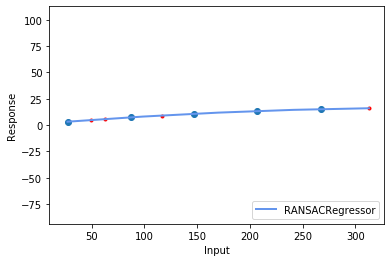

In [121]:
print("data.txt:")
print(pd.read_csv("data.txt", index_col =  None, header = None).to_string(header = ["x","y"], index = False))

cache = polyfit("data.txt",2,0.5,disable_linear = False)

al = arclength(cache)
print("arclength:"+str(al["arclength"]))
#x_coordinates of evenly spaced segments
output = spacing(al, 60.218)
print(output)

print(cache["model"].predict(output))

plt.scatter(output, cache["model"].predict(output))

pd.DataFrame({'x':output, 'y': cache["model"].predict(output)})

#plt.plot(x,y)

#pd.DataFrame(x,y)

In [123]:
process_data("test_data/test_data", 60.218, False)

MSE of the linear fit: 510.3091929938507
MSE of the polynomial fit: 142.07500450050367
Polynomial model chosen
(456.9141927845878, 2771.9029332154128)
(126.64579752580471, 2441.63453795663)
MSE of the linear fit: 945.4463670435078
MSE of the polynomial fit: 754.2872753347217
Polynomial model chosen
(1843.7039824845876, 3458.043967515412)
(2230.376579114931, 3844.716564145755)
MSE of the linear fit: 454.1168451991766
MSE of the polynomial fit: 362.55755121028005
Polynomial model chosen
(471.45822543458775, 2008.6920395654117)
(3404.680319357511, 4941.914133488335)
MSE of the linear fit: 418001.1988256091
MSE of the polynomial fit: 416932.8602702896
Polynomial model chosen
(1648.3717078345871, 3373.7116511654126)
(572.9246439995889, 2298.2645873304145)
MSE of the linear fit: 27.301927723108317
MSE of the polynomial fit: 28.208104582546962
Linear model chosen
(376.7346098345878, 1469.7741371654117)
(1064.5934047274031, 2157.632932058227)
MSE of the linear fit: 53.32015249689025
MSE of the

MSE of the linear fit: 43008.45126729834
MSE of the polynomial fit: 42475.76070988706
Polynomial model chosen
(253.07686928458781, 2079.043306715412)
(-370.0684192154124, 1455.898018215412)
MSE of the linear fit: 96.0339619781325
MSE of the polynomial fit: 35.108917990804954
Polynomial model chosen
(225.77490223458778, 1777.956730765412)
(263.22532553254314, 1815.4071540633672)
MSE of the linear fit: 77260.15775931095
MSE of the polynomial fit: 76898.59218273408
Polynomial model chosen
(2214.806881334588, 3525.2089936654115)
(-121.19372466541176, 1189.2083876654117)
MSE of the linear fit: 61112.09704132627
MSE of the polynomial fit: 60771.1351842926
Polynomial model chosen
(2323.371892584588, 3503.5476174154123)
(410.8625765845877, 1591.0383014154122)
MSE of the linear fit: 52.7384793527648
MSE of the polynomial fit: 29.7050714552113
Polynomial model chosen
(882.0833222345877, 1912.2385687654119)
(963.963655435068, 1994.118901965892)
MSE of the linear fit: 42517.4090139236
MSE of the p

(4496.941779884588, 5482.311128115412)
(1328.4536886886917, 2313.823036919516)
MSE of the linear fit: 252.32214355345022
MSE of the polynomial fit: 228.74440632171545
Polynomial model chosen
(2854.2088031345875, 4133.085183865413)
(58.7949867309884, 1337.6713674618136)
MSE of the linear fit: 531553.4326815765
MSE of the polynomial fit: 529751.3650260868
Polynomial model chosen
(3683.8487022845875, 5518.636017715412)
(-25.241900498675022, 1809.5454149321495)
MSE of the linear fit: 429.9151199158394
MSE of the polynomial fit: 375.9270759626589
Polynomial model chosen
(4543.8242643345875, 5471.834740665413)
(132.73980433458735, 1060.750280665413)
MSE of the linear fit: 41596.5963773143
MSE of the polynomial fit: 41466.61756723744
Polynomial model chosen
(2224.437652784588, 3811.1163492154124)
(2761.991108520927, 4348.669804951752)
MSE of the linear fit: 303.0474561787708
MSE of the polynomial fit: 263.4989309998153
Polynomial model chosen
(248.62845968458777, 1842.3340023154121)
(2219.234

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 10069.479880165003
MSE of the polynomial fit: 10783.240411921752
Linear model chosen
(2080.9757050845883, 3632.5587189154116)
(1627.6220079193934, 3179.2050217502165)
MSE of the linear fit: 10743.799257245022
MSE of the polynomial fit: 11224.949592469675
Linear model chosen
(2169.147254334588, 3665.2235806654116)
(1190.0228177470685, 2686.099144077892)
MSE of the linear fit: 614651.3733800559
MSE of the polynomial fit: 605405.9145672952
Polynomial model chosen
(2109.5878692345877, 3686.388511765412)
(3566.292125734586, 5143.092768265411)
MSE of the linear fit: 565.1454679825059
MSE of the polynomial fit: 499.8694393855294
Polynomial model chosen
(1825.7976970845875, 3262.0987529154118)
(683.1282672523148, 2119.429323083139)
MSE of the linear fit: 1645486.2842302124
MSE of the polynomial fit: 1654033.630790689
Linear model chosen
(217.35658498458778, 3274.6701130154115)
(2776.904400621819, 5834.2179286526425)
MSE of the linear fit: 587329.9463781473
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 99920.66702409224
MSE of the polynomial fit: 98980.23431349052
Polynomial model chosen
(3838.858862484588, 5323.604525515412)
(1278.0688744845882, 2762.8145375154127)
MSE of the linear fit: 177960.44494787575
MSE of the polynomial fit: 182954.34295449642
Linear model chosen
(674.7693135345878, 2752.225731465412)
(1988.8965521142, 4066.3529700450244)
MSE of the linear fit: 495379.0784232876
MSE of the polynomial fit: 495784.1110508364
Linear model chosen
(377.5411794345878, 1990.4793475654121)
(1626.3177399520541, 3239.2559080828782)
MSE of the linear fit: 22951.371271600095
MSE of the polynomial fit: 23031.57047130146
Linear model chosen
(4457.221926134587, 5167.721134865412)
(2836.5869178638527, 3547.0861265946774)
MSE of the linear fit: 70241.97009707516
MSE of the polynomial fit: 69719.77783905187
Polynomial model chosen
(4080.4137059845875, 5436.93909001541)
(1832.3070598052389, 3188.8324438360614)
MSE of the linear fit: 60074.52277572246
MSE of the polynomia

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 96353.28835567794
MSE of the polynomial fit: 98400.21336611976
Linear model chosen
(271.91716153458776, 1283.5606334654121)
(3550.50788966793, 4562.151361598754)
MSE of the linear fit: 175.95147465553663
MSE of the polynomial fit: 161.31486210179926
Polynomial model chosen
(258.9461935345878, 1137.5613194654118)
(3103.0326640014173, 3981.647789932241)
MSE of the linear fit: 420.14770674519787
MSE of the polynomial fit: 382.76676861565096
Polynomial model chosen
(580.3194063345878, 1890.587384665412)
(152.995169544786, 1463.26314787561)
MSE of the linear fit: 622.7878030755621
MSE of the polynomial fit: 684.4877961006816
Linear model chosen
(280.42517783458777, 2226.458341165412)
(381.4754590710372, 2327.5086224018614)
MSE of the linear fit: 600979.1406942824
MSE of the polynomial fit: 596430.9687090679
Polynomial model chosen
(2031.999877684588, 3859.6165483154127)
(2087.842002783376, 3915.458673414201)
MSE of the linear fit: 443.26772666613203
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 69.37609324568581
MSE of the polynomial fit: 61.82962553737167
Polynomial model chosen
(3522.1126026345883, 4758.7239143654115)
(1089.5814196345882, 2326.1927313654114)
MSE of the linear fit: 265.3763007095205
MSE of the polynomial fit: 220.85753183933687
Polynomial model chosen
(1591.6691041345878, 2721.3012028654125)
(2700.945396134587, 3830.5774948654116)
MSE of the linear fit: 86740.15891780113
MSE of the polynomial fit: 86339.72564039884
Polynomial model chosen
(3126.4025402845878, 4715.9069937154145)
(1581.6390567252604, 3171.1435101560874)
MSE of the linear fit: 27716.14845100215
MSE of the polynomial fit: 28040.642662991046
Linear model chosen
(3760.8525837845878, 4394.461338215411)
(889.3343937084908, 1522.9431481393142)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 559.0494644306289
MSE of the polynomial fit: 530.6810902181041
Polynomial model chosen
(384.2254679345877, 1155.7738670654119)
(4738.678315933808, 5510.226715064633)
MSE of the linear fit: 456.42761772154034
MSE of the polynomial fit: 433.25198660022636
Polynomial model chosen
(3572.761821684587, 4435.096790315413)
(1330.391674509916, 2192.726643140742)
MSE of the linear fit: 25636.24877881912
MSE of the polynomial fit: 25437.388503502912
Polynomial model chosen
(3000.113728734588, 3778.417804265412)
(2377.714843734588, 3156.018919265412)
MSE of the linear fit: 252.9649722265615
MSE of the polynomial fit: 55.59943364603227
Polynomial model chosen
(1151.9998599345877, 2739.1242510654124)
(467.26796575216144, 2054.392356882986)
MSE of the linear fit: 336257.2058410717
MSE of the polynomial fit: 334767.7575949615
Polynomial model chosen
(2211.927985934588, 3799.8437610654123)
(1658.1887614345876, 3246.1045365654118)
MSE of the linear fit: 418.3363679083729
MSE of th

MSE of the linear fit: 360.92399738927804
MSE of the polynomial fit: 378.81601526695624
Linear model chosen
(3689.198135234588, 5105.673381765414)
(1282.6964506014554, 2699.171697132281)
MSE of the linear fit: 111203.81801293152
MSE of the polynomial fit: 112211.43723855175
Linear model chosen
(2085.004430134588, 2900.4581588654123)
(164.48862463458772, 979.9423533654121)
MSE of the linear fit: 188084.45176971002
MSE of the polynomial fit: 188971.0008088278
Linear model chosen
(1968.725395684588, 3880.7894843154118)
(270.5442651845881, 2182.6083538154116)
MSE of the linear fit: 38763.63466193741
MSE of the polynomial fit: 38633.994671812936
Polynomial model chosen
(335.1395909345878, 1194.758434065412)
(472.7667414345878, 1332.385584565412)
MSE of the linear fit: 28073.290022314104
MSE of the polynomial fit: 28564.042493023448
Linear model chosen
(304.8146690845878, 1254.7713609154118)
(1573.502990490415, 2523.4596823212387)
MSE of the linear fit: 83015.29592145045
MSE of the polynomia

MSE of the linear fit: 246.0782848168006
MSE of the polynomial fit: 190.64876937016817
Polynomial model chosen
(309.4724884845877, 1889.991015515412)
(3914.377320512991, 5494.895847543816)
MSE of the linear fit: 127508.77610279473
MSE of the polynomial fit: 126875.7504267883
Polynomial model chosen
(4263.613405734588, 5493.342059265411)
(775.29941681032, 2005.0280703411431)
MSE of the linear fit: 32.215994660667754
MSE of the polynomial fit: 8.795074777274523
Polynomial model chosen
(925.0616473845879, 1794.7809666154121)
(1639.4908885370642, 2509.2102077678883)
MSE of the linear fit: 65058.38647316227
MSE of the polynomial fit: 65532.86742408633
Linear model chosen
(2215.778409084588, 3835.6706529154117)
(921.220862529256, 2541.1131063600797)
MSE of the linear fit: 74684.10879270863
MSE of the polynomial fit: 74933.01378063817
Linear model chosen
(4199.886310134589, 5041.029416865413)
(600.8589201825268, 1442.0020269133508)
MSE of the linear fit: 105.71286290861933
MSE of the polynomi

MSE of the linear fit: 544.9651553022887
MSE of the polynomial fit: 528.1856303053127
Polynomial model chosen
(319.0243304845878, 1139.4831175154122)
(3284.495160984588, 4104.953948015413)
MSE of the linear fit: 24585.861123570798
MSE of the polynomial fit: 25117.482275350678
Linear model chosen
(208.65197888458772, 2494.7732191154123)
(784.5119558524477, 3070.633196083272)
MSE of the linear fit: 623.9331800234712
MSE of the polynomial fit: 693.6675558931105
Linear model chosen
(4054.8458134845882, 4654.276210515412)
(2198.459072211557, 2797.889469242381)
MSE of the linear fit: 515.4297842295833
MSE of the polynomial fit: 518.0419115580744
Linear model chosen
(4595.378516884587, 5144.885339115412)
(897.9368273845878, 1447.4436496154124)
MSE of the linear fit: 465.5721806869124
MSE of the polynomial fit: 500.06355849889536
Linear model chosen
(286.00679758458784, 1093.1606424154122)
(508.73551571551974, 1315.889360546344)
MSE of the linear fit: 156676.42756324302
MSE of the polynomial f

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 588.5276296069597
MSE of the polynomial fit: 592.2584716260545
Linear model chosen
(235.50869858458782, 876.7910354154121)
(250.7721993209425, 892.0545361517668)
MSE of the linear fit: 176.29168850926007
MSE of the polynomial fit: 187.3326078388383
Linear model chosen
(324.32056583458785, 2346.283253165412)
(2576.2638703345874, 4598.226557665412)
MSE of the linear fit: 11.04635722358363
MSE of the polynomial fit: 10.919111287051061
Polynomial model chosen
(215.63234033458775, 3161.273750665412)
(-796.2911963502752, 2149.350213980549)
MSE of the linear fit: 16.52899807713679
MSE of the polynomial fit: 16.88040108455742
Linear model chosen
(4580.779379734588, 5429.2356032654125)
(-45.20339666147163, 803.2528268693533)
MSE of the linear fit: 47.31413468670452
MSE of the polynomial fit: 6.693047490126832
Polynomial model chosen
(358.01546698458776, 1645.2301370154119)
(1910.709800025148, 3197.924470055972)
MSE of the linear fit: 197.25040469971643
MSE of the polynomi

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 277.6822277073624
MSE of the polynomial fit: 279.91066523543844
Linear model chosen
(4170.550545334588, 5514.996601665411)
(1669.2405645648819, 3013.686620895705)
MSE of the linear fit: 433.17371240745047
MSE of the polynomial fit: 401.75805877406304
Polynomial model chosen
(3797.539449584588, 5463.455726415414)
(1952.2960578589348, 3618.2123346897606)
MSE of the linear fit: 115.41958831515437
MSE of the polynomial fit: 80.56272243458767
Polynomial model chosen
(3750.575900284587, 5450.480599715412)
(2428.4279232845875, 4128.332622715412)
MSE of the linear fit: 111.04590584223256
MSE of the polynomial fit: 125.26533573126953
Linear model chosen
(3579.582832684588, 4819.076693315414)
(2999.614855483125, 4239.108716113951)
MSE of the linear fit: 9952.346430174784
MSE of the polynomial fit: 9909.722950119109
Polynomial model chosen
(3297.1132047845886, 5030.302485215412)
(2416.841599284588, 4150.030879715412)
MSE of the linear fit: 279711.5155084833
MSE of the polyn

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 327.6309161919622
MSE of the polynomial fit: 313.61592467225825
Polynomial model chosen
(262.3990726845878, 899.928669315412)
(1569.6601832717524, 2207.189779902577)
MSE of the linear fit: 474.0924533483471
MSE of the polynomial fit: 436.91201303377215
Polynomial model chosen
(750.5946693845877, 1606.2381686154117)
(1509.2229747776828, 2364.866474008507)
MSE of the linear fit: 720.7259541678052
MSE of the polynomial fit: 681.7619609077002
Polynomial model chosen
(917.9513380845879, 1897.7515579154121)
(900.167850109389, 1879.9680699402134)
MSE of the linear fit: 512.1528211423016
MSE of the polynomial fit: 569.0863160972917
Linear model chosen
(2585.029771234588, 4267.413341765411)
(2323.510012675515, 4005.893583206338)
MSE of the linear fit: 362.8915060959801
MSE of the polynomial fit: 439.99335504312256
Linear model chosen
(2521.669759340615, 3652.560339659385)
(868.471663258037, 1999.3622435768073)
MSE of the linear fit: 465.1801179886087
MSE of the polynomial

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 1246.819179537805
MSE of the polynomial fit: 1350.5855032878287
Linear model chosen
(884.2622558845877, 2873.1610761154125)
(3669.4795958774284, 5658.378416108253)
MSE of the linear fit: 37.17012291543919
MSE of the polynomial fit: 43.57049429427079
Linear model chosen
(797.450100284588, 3653.362289715412)
(2593.098317036352, 5449.010506467175)
MSE of the linear fit: 55.500797080608685
MSE of the polynomial fit: 24.805968771886
Polynomial model chosen
(1128.6792338845876, 3701.830624115412)
(3185.307721208593, 5758.459111439417)
MSE of the linear fit: 313.1708512719392
MSE of the polynomial fit: 26.697273748336382
Polynomial model chosen
(290.41314043458783, 2952.3778585654118)
(1702.080763934588, 4364.045482065412)
MSE of the linear fit: 231.1086898746294
MSE of the polynomial fit: 260.76391799576794
Linear model chosen
(4444.10767188459, 5472.37871411541)
(2472.030929745506, 3500.301971976326)
MSE of the linear fit: 389.3786850924293
MSE of the polynomial fit: 

MSE of the linear fit: 37483.888058695906
MSE of the polynomial fit: 37761.977574901626
Linear model chosen
(207.5733760345878, 1940.935658965412)
(370.33952346233946, 2103.7018063931637)
MSE of the linear fit: 166056.8383222578
MSE of the polynomial fit: 165746.2008291965
Polynomial model chosen
(2136.590571784588, 3739.101062215412)
(3555.3005462764622, 5157.811036707287)
MSE of the linear fit: 209854.43025964018
MSE of the polynomial fit: 211397.68557558235
Linear model chosen
(1985.656393534588, 3824.4678994654114)
(2910.4482478344944, 4749.259753765318)
MSE of the linear fit: 209522.76170006514
MSE of the polynomial fit: 211479.09252575831
Linear model chosen
(2049.896642184588, 3832.234199815412)
(2398.027260034016, 4180.36481766484)
MSE of the linear fit: 144.15173752808852
MSE of the polynomial fit: 73.032709944322
Polynomial model chosen
(324.7735213845878, 1734.2614766154122)
(3265.386171069237, 4674.874126300062)
MSE of the linear fit: 46209.473640080156
MSE of the polynomia

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 216.63072623580902
MSE of the polynomial fit: 29.62378468394479
Polynomial model chosen
(173.93036533458778, 3481.343141665412)
(1563.963211834588, 4871.375988165412)
MSE of the linear fit: 227919.54048144535
MSE of the polynomial fit: 228687.65007995823
Linear model chosen
(232.1108422845878, 1833.0827737154118)
(1050.7791891719305, 2651.751120602755)
MSE of the linear fit: 330716.12152418325
MSE of the polynomial fit: 332371.34066001367
Linear model chosen
(265.6312015845878, 2066.2819684154124)
(406.2311706264161, 2206.8819374572404)
MSE of the linear fit: 231008.80538089914
MSE of the polynomial fit: 230812.3280733522
Polynomial model chosen
(763.2795008845877, 2179.8603991154123)
(196.09235088458752, 1612.673249115412)
MSE of the linear fit: 93883.69154865741
MSE of the polynomial fit: 93954.61409718542
Linear model chosen
(1362.1804702845877, 2478.673285715412)
(42.09083288500233, 1158.5836483158266)
MSE of the linear fit: 106368.44212674977
MSE of the poly

MSE of the linear fit: 21.767346199187966
MSE of the polynomial fit: 2.503587249028895
Polynomial model chosen
(1382.468517334588, 2434.441469665412)
(221.13705801529818, 1273.1100103461224)
MSE of the linear fit: 11778.908520465575
MSE of the polynomial fit: 11767.792664211882
Polynomial model chosen
(295.92868738458776, 1067.254546615412)
(166.4316575599292, 937.7575167907535)
MSE of the linear fit: 178636.04416876507
MSE of the polynomial fit: 178048.93373284757
Polynomial model chosen
(1665.7817046845878, 2547.088879315412)
(1231.5346338165573, 2112.8418084473815)
MSE of the linear fit: 29.772731531387905
MSE of the polynomial fit: 18.57202331833122
Polynomial model chosen
(1040.5674369845876, 2200.6797690154126)
(517.6967964845875, 1677.8091285154123)
MSE of the linear fit: 78.91003368387008
MSE of the polynomial fit: 59.978169433716694
Polynomial model chosen
(848.6335937345879, 1705.0651692654121)
(3136.686298734588, 3993.1178742654124)
MSE of the linear fit: 119505.05075163122


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 457136.06711587176
MSE of the polynomial fit: 456876.4100814548
Polynomial model chosen
(2698.844721434588, 5271.496809565412)
(-295.74825924850734, 2276.9038288823167)
MSE of the linear fit: 285.776001498393
MSE of the polynomial fit: 279.9124625267529
Polynomial model chosen
(2052.782920234588, 3632.1172587654114)
(2771.1440167345886, 4350.478355265412)
MSE of the linear fit: 424.3558909114738
MSE of the polynomial fit: 434.9628692422181
Linear model chosen
(237.50860678458776, 2148.466885215412)
(2993.7506091120113, 4904.708887542835)
MSE of the linear fit: 187.6234650504562
MSE of the polynomial fit: 129.4146787911555
Polynomial model chosen
(246.85901708458783, 1727.731786915412)
(827.8267145319572, 2308.6994843627813)
MSE of the linear fit: 176.92652210011246
MSE of the polynomial fit: 4.6123522597907165
Polynomial model chosen
(296.5954057845878, 1550.6944042154119)
(2881.455312284588, 4135.554310715412)
MSE of the linear fit: 38898.24553048831
MSE of the 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 332.3043496330772
MSE of the polynomial fit: 337.3080292413898
Linear model chosen
(338.8168379845877, 1128.947712015412)
(1032.6002612763423, 1822.7311353071664)
MSE of the linear fit: 223478.3461375851
MSE of the polynomial fit: 221764.07832498706
Polynomial model chosen
(1604.1066725345877, 2751.346198465412)
(2166.6510328181193, 3313.8905587489435)
MSE of the linear fit: 659.5800280836183
MSE of the polynomial fit: 675.8103308913247
Linear model chosen
(855.4118917845877, 2089.760148215412)
(189.60298217549382, 1423.951238606318)
MSE of the linear fit: 362.6067905102023
MSE of the polynomial fit: 434.2510758955577
Linear model chosen
(3461.5089406845877, 4012.195781315412)
(2632.121238515856, 3182.80807914668)
MSE of the linear fit: 438.7147752857836
MSE of the polynomial fit: 376.9687006523822
Polynomial model chosen
(1111.8136813845877, 3894.3428006154118)
(-135.52399161541234, 2647.0051276154118)
MSE of the linear fit: 1123622.3494491254
MSE of the polynom

MSE of the linear fit: 19393.67990184719
MSE of the polynomial fit: 19223.848435442498
Polynomial model chosen
(2668.8893615845877, 3779.7021224154128)
(1583.8212425845873, 2694.6340034154123)
MSE of the linear fit: 402.2287374545494
MSE of the polynomial fit: 331.28555920166895
Polynomial model chosen
(899.2244728845876, 3996.3183371154114)
(621.9790718845879, 3719.0729361154117)
MSE of the linear fit: 265634.4194320145
MSE of the polynomial fit: 266747.8101466239
Linear model chosen
(1981.9574371845877, 4012.273428815413)
(1403.203384141003, 3433.519375771828)
MSE of the linear fit: 340.92904405031413
MSE of the polynomial fit: 333.2656017742321
Polynomial model chosen
(756.2124466845878, 1645.0654233154119)
(2999.080866186253, 3887.9338428170768)
MSE of the linear fit: 500.43103838629344
MSE of the polynomial fit: 458.8973018013354
Polynomial model chosen
(1487.3040296345878, 2256.998165365412)
(3205.144799334218, 3974.8389350650423)
MSE of the linear fit: 125286.91066008295
MSE of 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 283.9773471573268
MSE of the polynomial fit: 244.56564159777622
Polynomial model chosen
(686.0815653845877, 2005.3248166154121)
(-73.47673561541217, 1245.7665156154121)
MSE of the linear fit: 15746.199726820372
MSE of the polynomial fit: 15737.646208214435
Polynomial model chosen
(659.5348415345878, 1483.1836494654121)
(4643.629688534588, 5467.278496465412)
MSE of the linear fit: 4823.95429873178
MSE of the polynomial fit: 4781.076381963139
Polynomial model chosen
(1632.4531878345877, 2605.875525165412)
(1065.2451258512888, 2038.667463182113)
MSE of the linear fit: 104.645550627141
MSE of the polynomial fit: 8.81640185629322
Polynomial model chosen
(283.06256558458773, 1726.5228504154118)
(270.6755202816639, 1714.135805112488)
MSE of the linear fit: 8900.775987137711
MSE of the polynomial fit: 8474.9421584643
Polynomial model chosen
(2163.193511984587, 3842.4746040154123)
(282.28052798458725, 1961.5616200154125)
MSE of the linear fit: 5423.065246102798
MSE of the

MSE of the linear fit: 58232.25628103124
MSE of the polynomial fit: 58638.45594302501
Linear model chosen
(1708.6094677345875, 3145.7173812654123)
(2865.234257371124, 4302.3421709019485)
MSE of the linear fit: 172.3416363921001
MSE of the polynomial fit: 168.73964827965938
Polynomial model chosen
(278.16403673458774, 1404.396286265412)
(2382.0465710484573, 3508.2788205792817)
MSE of the linear fit: 33808.94267899701
MSE of the polynomial fit: 33428.82316777143
Polynomial model chosen
(1946.3338904345874, 3336.637426565412)
(2290.9947919345886, 3681.2983280654134)
MSE of the linear fit: 162.19690403015855
MSE of the polynomial fit: 152.38797475958398
Polynomial model chosen
(659.6516565345878, 1482.1186904654119)
(2037.587015330521, 2860.054049261345)
MSE of the linear fit: 30516.48108759724
MSE of the polynomial fit: 30412.03677946336
Polynomial model chosen
(2261.481213234588, 3604.789013765412)
(1857.9221206906996, 3201.229921221524)
MSE of the linear fit: 186.9555520082999
MSE of th

MSE of the linear fit: 31309.727510050394
MSE of the polynomial fit: 30838.590714168793
Polynomial model chosen
(2452.460691184588, 3842.315982815412)
(662.9528614022418, 2052.8081530330655)
MSE of the linear fit: 140764.40174060458
MSE of the polynomial fit: 141711.37637509377
Linear model chosen
(2566.063245434588, 3820.0877155654116)
(1500.8270700373835, 2754.851540168207)
MSE of the linear fit: 486.24211982660853
MSE of the polynomial fit: 474.893322329945
Polynomial model chosen
(1509.8306752345877, 2313.2080077654123)
(2604.044663932149, 3407.4219964629738)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 209314.5404225171
MSE of the polynomial fit: 211091.3834185113
Linear model chosen
(3576.358724884588, 4422.171271115413)
(378.5161465142221, 1224.3286927450474)
MSE of the linear fit: 353.32087026047225
MSE of the polynomial fit: 395.9889533892006
Linear model chosen
(4128.050143884588, 5272.2642661154105)
(-60.10435993108081, 1084.109762299742)
MSE of the linear fit: 132.23021273146963
MSE of the polynomial fit: 143.80791228206013
Linear model chosen
(2919.193386634588, 3518.195770365412)
(111.70065787576482, 710.7030416065888)
MSE of the linear fit: 157.65445482775334
MSE of the polynomial fit: 120.54195979496805
Polynomial model chosen
(256.18887578458776, 1196.5424422154117)
(2982.3756792089525, 3922.7292456397763)
MSE of the linear fit: 3871.037568570256
MSE of the polynomial fit: 3784.6302111207283
Polynomial model chosen
(1532.0080261345877, 2643.496262865412)
(1254.6676751238683, 2366.155911854693)
MSE of the linear fit: 267.67503425625625
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 13.252570987452525
MSE of the polynomial fit: 14.446536280896192
Linear model chosen
(2892.8201576845877, 3792.9963143154123)
(1286.1603068891798, 2186.336463520004)
MSE of the linear fit: 313.9452189131691
MSE of the polynomial fit: 275.97398813077723
Polynomial model chosen
(976.9791835345876, 2320.596385465412)
(4371.263818356629, 5714.881020287454)
MSE of the linear fit: 404.4568286229409
MSE of the polynomial fit: 399.6190705957519
Polynomial model chosen
(2911.5255705345876, 4229.713214465412)
(2526.4789944094564, 3844.6666383402817)
MSE of the linear fit: 359.8420114234025
MSE of the polynomial fit: 385.7261304354204
Linear model chosen
(2564.5293958845878, 4359.046644115412)
(2446.1056622363067, 4240.622910467131)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 89964.29085731626
MSE of the polynomial fit: 86344.79653457404
Polynomial model chosen
(3159.186761334587, 3794.8729856654118)
(4872.149286834587, 5507.835511165411)
MSE of the linear fit: 418.50641928422914
MSE of the polynomial fit: 436.84379178882244
Linear model chosen
(4824.094253984587, 5473.597476015413)
(1968.9076789503315, 2618.4109009811573)
MSE of the linear fit: 269.1850594597859
MSE of the polynomial fit: 246.5511487532337
Polynomial model chosen
(2373.486383784588, 3562.637378215412)
(2441.4444845251783, 3630.595478956002)
MSE of the linear fit: 749.8040554100938
MSE of the polynomial fit: 743.151874108222
Polynomial model chosen
(3979.294957134587, 5513.084501865413)
(1186.4444347418776, 2720.233979472703)
MSE of the linear fit: 210.18053860152327
MSE of the polynomial fit: 207.95305808967024
Polynomial model chosen
(468.7885469345879, 2202.402776065412)
(350.7812691021702, 2084.395498232994)
MSE of the linear fit: 19716.90764849083
MSE of the poly

MSE of the linear fit: 136.3603624118639
MSE of the polynomial fit: 41.80694697289959
Polynomial model chosen
(1615.1913715845876, 2462.126276415412)
(1962.468217000592, 2809.4031218314167)
MSE of the linear fit: 9297.978553365943
MSE of the polynomial fit: 9663.330698240989
Linear model chosen
(2855.197189334588, 3745.577237665412)
(1247.8115941294625, 2138.191642460287)
MSE of the linear fit: 178.76924059892906
MSE of the polynomial fit: 21.573081794415533
Polynomial model chosen
(844.6397758345879, 2424.431921165413)
(1116.4799115932913, 2696.2720569241164)
MSE of the linear fit: 10901.396769921605
MSE of the polynomial fit: 10949.330410085873
Linear model chosen
(2987.7021260845877, 3809.634679915412)
(761.0553788780505, 1582.987932708875)
MSE of the linear fit: 25931.580018249984
MSE of the polynomial fit: 26448.825057288366
Linear model chosen
(2449.0090613845887, 3750.937828615412)
(2998.8699056518963, 4300.798672882719)
MSE of the linear fit: 21533.229672729904
MSE of the polyn

MSE of the linear fit: 355.114768966258
MSE of the polynomial fit: 320.7356625483273
Polynomial model chosen
(1279.992152384588, 1875.8218116154121)
(2789.959695693324, 3385.7893549241485)
MSE of the linear fit: 364.2672586763893
MSE of the polynomial fit: 399.5849826744279
Linear model chosen
(1064.6908703345875, 1881.4187026654122)
(936.2476495066885, 1752.9754818375131)
MSE of the linear fit: 41823.46510461251
MSE of the polynomial fit: 41332.136299812824
Polynomial model chosen
(2088.470596234588, 3808.4806347654117)
(3855.6204542345868, 5575.63049276541)
MSE of the linear fit: 93.17888661923318
MSE of the polynomial fit: 51.47560123607194
Polynomial model chosen
(269.5974321845878, 1673.4261778154118)
(4108.422989684586, 5512.251735315411)
MSE of the linear fit: 632.701273254697
MSE of the polynomial fit: 672.4288758816248
Linear model chosen
(218.2921912345878, 1061.4711537654123)
(3054.9262280119783, 3898.105190542803)
MSE of the linear fit: 156.49221046844428
MSE of the polynom

MSE of the linear fit: 22.04936954062644
MSE of the polynomial fit: 14.355294414739076
Polynomial model chosen
(281.7478852345878, 1396.612877765412)
(2754.090948766482, 3868.955941297306)
MSE of the linear fit: 15640.300440880117
MSE of the polynomial fit: 15661.110275751122
Linear model chosen
(1759.2806456345877, 2988.781205365412)
(1895.927272269324, 3125.4278320001486)
MSE of the linear fit: 376.2761438483622
MSE of the polynomial fit: 350.5609002328094
Polynomial model chosen
(689.1121491845876, 2426.9747268154124)
(1076.9133251845872, 2814.7759028154123)
MSE of the linear fit: 1087.3356238980903
MSE of the polynomial fit: 1264.6258035441165
Linear model chosen
(1765.4855128845875, 3658.6366371154113)
(-72.04325892106726, 1821.1078653097566)
MSE of the linear fit: 96.90623550074022
MSE of the polynomial fit: 218.76629901733364
Linear model chosen
(1640.4351750345875, 3411.077535965412)
(520.5907644312732, 2291.233125362098)
MSE of the linear fit: 69.26680669253585
MSE of the poly

MSE of the linear fit: 429.2867948752045
MSE of the polynomial fit: 449.2731888570811
Linear model chosen
(285.3441535845878, 1288.201286415412)
(1722.6324557142007, 2725.489588545025)
MSE of the linear fit: 429156.7386788824
MSE of the polynomial fit: 432186.8950753033
Linear model chosen
(2522.969214584588, 3865.619053415412)
(3179.3134949114165, 4521.96333374224)
MSE of the linear fit: 410.8262404778029
MSE of the polynomial fit: 377.3553027777562
Polynomial model chosen
(402.2352560345878, 2214.467428965412)
(1629.7339865993094, 3441.9661595301336)
MSE of the linear fit: 323.2556816731825
MSE of the polynomial fit: 326.26164193956635
Linear model chosen
(257.20801338458784, 1557.2796286154116)
(3443.508701884587, 4743.580317115411)
MSE of the linear fit: 369262.91481845215
MSE of the polynomial fit: 364554.8132574666
Polynomial model chosen
(196.5371936345878, 2699.978311365412)
(3164.2012351345866, 5667.642352865411)
MSE of the linear fit: 490.5998325818725
MSE of the polynomial f

MSE of the linear fit: 543.8357849616469
MSE of the polynomial fit: 545.4228771640802
Linear model chosen
(1279.4465084845876, 2472.665419515412)
(4352.11361019492, 5545.332521225744)
MSE of the linear fit: 322.23549175884006
MSE of the polynomial fit: 324.0437950478963
Linear model chosen
(4626.487983284589, 5190.315146715413)
(161.10879128458805, 724.935954715412)
MSE of the linear fit: 178.3338123013436
MSE of the polynomial fit: 181.4627058521845
Linear model chosen
(314.4195038845878, 1074.125876115412)
(2969.4004270010555, 3729.1067992318794)
MSE of the linear fit: 85.4725482910629
MSE of the polynomial fit: 14.101507455905628
Polynomial model chosen
(219.6244799345877, 3441.2293890654128)
(-931.3524922188659, 2290.2524169119592)
MSE of the linear fit: 1166009.5536162239
MSE of the polynomial fit: 1164530.9477050696
Polynomial model chosen
(199.12696738458783, 2276.384024615412)
(160.825231884588, 2238.082289115412)
MSE of the linear fit: 1997205.7999727598
MSE of the polynomial 

MSE of the linear fit: 17902.134902283746
MSE of the polynomial fit: 18094.323825759322
Linear model chosen
(238.3098925845878, 1455.4205154154117)
(1578.305031394071, 2795.4156542248948)
MSE of the linear fit: 625661.232766443
MSE of the polynomial fit: 625261.0118653467
Polynomial model chosen
(1546.4537896845873, 3823.8181543154124)
(1457.6496886845869, 3735.0140533154117)
MSE of the linear fit: 977.4660347824157
MSE of the polynomial fit: 1226.7216050410727
Linear model chosen
(305.88053798458776, 1516.8674300154123)
(2718.8195613697603, 3929.806453400585)
MSE of the linear fit: 409204.2261684624
MSE of the polynomial fit: 403777.9307873789
Polynomial model chosen
(3104.7496936845882, 5029.750552315411)
(-140.90340831541153, 1784.0974503154116)
MSE of the linear fit: 128576.91530361235
MSE of the polynomial fit: 127254.76424377282
Polynomial model chosen
(4523.551603934588, 5487.36328306541)
(121.02836461214315, 1084.8400437429652)
MSE of the linear fit: 177.04070701550208
MSE of t

MSE of the linear fit: 428.3041261582903
MSE of the polynomial fit: 457.05392685473583
Linear model chosen
(271.5829588845878, 1500.343609115412)
(234.89591760401242, 1463.6565678348366)
MSE of the linear fit: 167708.45063467778
MSE of the polynomial fit: 168165.03934913452
Linear model chosen
(2704.2777360345876, 3456.782668965412)
(4631.375578147655, 5383.880511078479)
MSE of the linear fit: 3339.1573915633912
MSE of the polynomial fit: 3146.214247216573
Polynomial model chosen
(3813.7707428845883, 5373.579341115412)
(838.8722785409182, 2398.6808767717416)
MSE of the linear fit: 33897.36436849984
MSE of the polynomial fit: 34346.91630046977
Linear model chosen
(424.0287940345878, 1278.880608965412)
(1715.772009644904, 2570.623824575728)
MSE of the linear fit: 43732.07627186491
MSE of the polynomial fit: 43971.174599338854
Linear model chosen
(344.17054993458777, 1495.7419330654122)
(1067.5208700754313, 2219.092253206256)
MSE of the linear fit: 658686.9147811407
MSE of the polynomial 

MSE of the linear fit: 67.43919258157018
MSE of the polynomial fit: 63.877728891628564
Polynomial model chosen
(386.1904235345878, 1379.2623534654122)
(274.11495903458786, 1267.1868889654122)
MSE of the linear fit: 266655.5756654991
MSE of the polynomial fit: 267285.7122615567
Linear model chosen
(4369.495401484588, 5380.891572515413)
(990.4999001137712, 2001.8960711445961)
MSE of the linear fit: 216.92944273063765
MSE of the polynomial fit: 191.6672344744111
Polynomial model chosen
(2243.7306699345877, 3098.6259810654124)
(3041.8715228501783, 3896.766833981003)
MSE of the linear fit: 729172.7668181749
MSE of the polynomial fit: 730112.2696417703
Linear model chosen
(3509.335896784588, 5235.18525121541)
(393.76495430269233, 2119.6143087335145)
MSE of the linear fit: 719243.7487218259
MSE of the polynomial fit: 719973.8220132918
Linear model chosen
(2807.519345484588, 4507.611370515412)
(326.22533525507765, 2026.3173602859017)
MSE of the linear fit: 745237.8675374606
MSE of the polynomi

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 10665.048932732305
MSE of the polynomial fit: 12277.137597957688
Linear model chosen
(2844.468690234588, 3757.377290765412)
(1748.0892927345883, 2660.997893265412)
MSE of the linear fit: 1067357.1011744821
MSE of the polynomial fit: 1010641.1567267712
Polynomial model chosen
(306.8374269345878, 3859.8030580654117)
(1542.2321169345876, 5095.197748065411)
MSE of the linear fit: 793915.9899939728
MSE of the polynomial fit: 789628.9081724767
Polynomial model chosen
(858.7045277345876, 3823.0900612654127)
(1186.167845734587, 4150.553379265412)
MSE of the linear fit: 463.0195062910342
MSE of the polynomial fit: 438.12310934309323
Polynomial model chosen
(457.8824949345877, 1825.604802065412)
(1966.7530033310127, 3334.475310461837)
MSE of the linear fit: 185.00406810033743
MSE of the polynomial fit: 200.20474184340478
Linear model chosen
(409.6539904845878, 1292.803757515412)
(488.143846999313, 1371.2936140301372)
MSE of the linear fit: 148.0550464551302
MSE of the poly

MSE of the linear fit: 755347.7427291219
MSE of the polynomial fit: 765719.1612809333
Linear model chosen
(265.8078275845878, 3827.0026324154114)
(1739.152487190421, 5300.347292021244)
MSE of the linear fit: 324215.2415821668
MSE of the polynomial fit: 324414.65729824814
Linear model chosen
(302.0658268345877, 2651.9311881654126)
(2511.033267727399, 4860.898629058223)
MSE of the linear fit: 43693.5200612576
MSE of the polynomial fit: 43929.32144288417
Linear model chosen
(386.8089343345878, 3739.0792046654124)
(3456.9528067173605, 6809.223077048185)
MSE of the linear fit: 680.7287852657648
MSE of the polynomial fit: 685.6432760519377
Linear model chosen
(438.12029153458775, 1674.388075465412)
(284.82647381429626, 1521.0942577451206)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 121148.12189161159
MSE of the polynomial fit: 121180.59187305298
Linear model chosen
(2927.169456834588, 3662.714242165412)
(454.4734732005843, 1190.0182585314085)
MSE of the linear fit: 58641.00416561046
MSE of the polynomial fit: 61794.96875525052
Linear model chosen
(293.8821823345877, 3748.2932166654123)
(337.889797487946, 3792.300831818771)
MSE of the linear fit: 42474.66790221663
MSE of the polynomial fit: 38524.410057555826
Polynomial model chosen
(507.6520882845879, 3769.6953657154118)
(-79.37078121541208, 3182.6724962154117)
MSE of the linear fit: 40799.87601288745
MSE of the polynomial fit: 40043.570026649766
Polynomial model chosen
(629.4361536845878, 3627.2720943154122)
(-461.9841303491205, 2535.8518102817043)
MSE of the linear fit: 30134.253662138075
MSE of the polynomial fit: 29872.882919885666
Polynomial model chosen
(514.0919707845878, 3766.7775372154124)
(-1101.586823215412, 2151.0987432154125)
MSE of the linear fit: 153344.53705610402
MSE of the

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 10906.443231187219
MSE of the polynomial fit: 11496.678897056348
Linear model chosen
(1745.7542818345873, 3624.962621165412)
(-127.5633719222833, 1751.6449674085416)
MSE of the linear fit: 60.819910541837345
MSE of the polynomial fit: 52.51041389684076
Polynomial model chosen
(350.5896255345877, 1351.091659465412)
(3790.184967506042, 4790.687001436867)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 93.72959018975315
MSE of the polynomial fit: 58.263959105336596
Polynomial model chosen
(528.2606086345878, 1677.7249483654123)
(4194.840814634588, 5344.305154365413)
MSE of the linear fit: 260757.7476636742
MSE of the polynomial fit: 261621.97913805742
Linear model chosen
(2308.0856640345883, 3869.4551589654125)
(459.82737805604825, 2021.1968729868724)
MSE of the linear fit: 62.35984676268798
MSE of the polynomial fit: 99.53117238987073
Linear model chosen
(435.0890337345879, 2332.1752792654124)
(-426.08126484940556, 1471.004980681419)
MSE of the linear fit: 873512.8492245399
MSE of the polynomial fit: 893783.5124615628
Linear model chosen
(272.9611158845878, 2129.977328115412)
(1245.8455886147951, 3102.8618008456197)
MSE of the linear fit: 72323.44772995332
MSE of the polynomial fit: 72786.07241934202
Linear model chosen
(1315.8563214845876, 1860.3584825154119)
(4764.471154632931, 5308.973315663756)
MSE of the linear fit: 228886.6246269888
MSE of the polynomial

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 355862.73572590365
MSE of the polynomial fit: 357899.22949005145
Linear model chosen
(2710.0911806345875, 4173.322666365411)
(179.96136028787305, 1643.1928460186969)
MSE of the linear fit: 826195.0869173224
MSE of the polynomial fit: 821530.3555523817
Polynomial model chosen
(1718.4709507345876, 3826.5652462654125)
(1790.5763597345876, 3898.6706552654123)
MSE of the linear fit: 1129728.241211794
MSE of the polynomial fit: 1127886.3718677037
Polynomial model chosen
(396.47064483458774, 2673.428908165412)
(1680.1131205873555, 3957.07138391818)
MSE of the linear fit: 12357.35691680718
MSE of the polynomial fit: 12276.921733132527
Polynomial model chosen
(2895.0209154845875, 3747.957224515412)
(1468.2752951417133, 2321.2116041725376)
MSE of the linear fit: 220.42225974615675
MSE of the polynomial fit: 127.44779102556502
Polynomial model chosen
(683.0327930345877, 2500.036743965412)
(2138.214580394082, 3955.2185313249065)
MSE of the linear fit: 598.715484909845
MSE of

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 98.61684654412537
MSE of the polynomial fit: 47.69944330456902
Polynomial model chosen
(591.6668508345879, 2105.824790165412)
(1733.6926994690446, 3247.8506387998686)
MSE of the linear fit: 158.4663740528388
MSE of the polynomial fit: 158.99932054598855
Linear model chosen
(2717.363780284588, 4172.242929715412)
(2804.0284374670546, 4258.907586897879)
MSE of the linear fit: 345800.92343638814
MSE of the polynomial fit: 340918.0679891663
Polynomial model chosen
(2914.731895384588, 5402.708624615414)
(-134.66482711541312, 2353.311902115413)
MSE of the linear fit: 222.23488322681195
MSE of the polynomial fit: 29.572682047120267
Polynomial model chosen
(336.9967516345878, 2322.0378553654123)
(1088.1551321345876, 3073.196235865412)
MSE of the linear fit: 55721.118373950274
MSE of the polynomial fit: 54896.43679156754
Polynomial model chosen
(579.1018246845878, 2143.436069315412)
(1798.5186911845876, 3362.852935815412)
MSE of the linear fit: 23719.24331747911
MSE of the

MSE of the linear fit: 3249.3960112393306
MSE of the polynomial fit: 2560.2586782896624
Polynomial model chosen
(2240.647609834588, 3616.137789165412)
(3768.6922621941394, 5144.182441524963)
MSE of the linear fit: 65038.49679542041
MSE of the polynomial fit: 65067.40268649313
Linear model chosen
(2728.420135584588, 3808.210234415412)
(94.29960605731185, 1174.0897048881357)
MSE of the linear fit: 197203.59485250965
MSE of the polynomial fit: 196804.09029590822
Polynomial model chosen
(1860.4755909345877, 3430.3921980654127)
(-7.842817441346597, 1562.0737896894784)
MSE of the linear fit: 221252.72671230912
MSE of the polynomial fit: 217995.508095438
Polynomial model chosen
(1838.1803946845878, 3698.079249315412)
(570.4489861845879, 2430.3478408154124)
MSE of the linear fit: 13153.336575606269
MSE of the polynomial fit: 14082.100674813628
Linear model chosen
(354.20414738458777, 3503.545052615412)
(595.2244832432687, 3744.5653884740923)
MSE of the linear fit: 3317.251322154752
MSE of the 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 15376.795914984472
MSE of the polynomial fit: 15545.862591453923
Linear model chosen
(4369.553092834587, 5351.140994165412)
(1377.2510338345874, 2358.8389351654123)
MSE of the linear fit: 15434.02283767552
MSE of the polynomial fit: 15388.496091105595
Polynomial model chosen
(2297.640956534588, 2910.770708465412)
(5037.7177395752715, 5650.847491506096)
MSE of the linear fit: 115.9112225307242
MSE of the polynomial fit: 48.269216227864334
Polynomial model chosen
(360.6426457845878, 1808.2118442154122)
(4207.207924179955, 5654.77712261078)
MSE of the linear fit: 989823.8917286017
MSE of the polynomial fit: 998752.9682332242
Linear model chosen
(2742.6570632345883, 5042.7880497654105)
(804.5101518318879, 3104.64113836271)
MSE of the linear fit: 104491.95449275266
MSE of the polynomial fit: 104211.44282206811
Polynomial model chosen
(3418.386124534589, 5403.3479424654115)
(209.87327153458864, 2194.8350894654113)
MSE of the linear fit: 110556.88187198692
MSE of the po

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 370278.8406013592
MSE of the polynomial fit: 370937.6657184115
Linear model chosen
(370.20720498458775, 1861.5391730154117)
(2512.1296132800735, 4003.4615813108976)
MSE of the linear fit: 264378.1401816259
MSE of the polynomial fit: 264828.12082473806
Linear model chosen
(1109.7768513345877, 2656.606363665412)
(2475.8093205950127, 4022.638832925837)
MSE of the linear fit: 612940.5970424692
MSE of the polynomial fit: 609551.8614862079
Polynomial model chosen
(2468.816142834588, 5061.619870165413)
(1258.3965393345877, 3851.2002666654125)
MSE of the linear fit: 233679.53881850812
MSE of the polynomial fit: 233188.2136686895
Polynomial model chosen
(434.35393588458794, 2221.663742115412)
(371.075540802311, 2158.385347033135)
MSE of the linear fit: 112486.5803478631
MSE of the polynomial fit: 112289.52834376744
Polynomial model chosen
(3770.238583084587, 4922.232824915413)
(2747.636252787968, 3899.6304946187943)
MSE of the linear fit: 288.30708660860387
MSE of the pol

MSE of the linear fit: 88.51355111709479
MSE of the polynomial fit: 20.94574630258226
Polynomial model chosen
(860.7158692845878, 2741.4518567154123)
(1238.8769632845876, 3119.612950715412)
MSE of the linear fit: 97732.95725297851
MSE of the polynomial fit: 95614.95613869024
Polynomial model chosen
(3056.1072265345874, 4845.273070465412)
(1689.2158954986858, 3478.3817394295106)
MSE of the linear fit: 73696.72014442984
MSE of the polynomial fit: 77772.09034388718
Linear model chosen
(2971.1055336845875, 4530.073406315412)
(2223.971007790079, 3782.938880420904)
MSE of the linear fit: 118.04682709799062
MSE of the polynomial fit: 32.16161470983137
Polynomial model chosen
(447.7398166845878, 2394.2497233154118)
(1641.9235579821375, 3588.4334646129614)
MSE of the linear fit: 83.59994025288538
MSE of the polynomial fit: 8.8235018469481
Polynomial model chosen
(756.6668481345878, 2283.6839568654123)
(2382.829622329785, 3909.8467310606093)
MSE of the linear fit: 65432.62058925523
MSE of the po

MSE of the linear fit: 54331.589646692366
MSE of the polynomial fit: 54223.78152277156
Polynomial model chosen
(2912.778855984588, 3685.7831480154114)
(1827.7376418657427, 2600.741933896566)
MSE of the linear fit: 1108743.8475112873
MSE of the polynomial fit: 1104043.516417004
Polynomial model chosen
(772.8175309345878, 3700.3366040654123)
(94.29703443458766, 3021.816107565412)
MSE of the linear fit: 933614.2876391211
MSE of the polynomial fit: 930918.191441066
Polynomial model chosen
(545.3276463345877, 3119.902624665412)
(-1.0725201654120156, 2573.5024581654125)
MSE of the linear fit: 536.2583118809252
MSE of the polynomial fit: 573.4977779116846
Linear model chosen
(1241.3318512845876, 2109.836860715412)
(23.975574332420365, 892.4805837632448)
MSE of the linear fit: 141.0360852395988
MSE of the polynomial fit: 105.87811073794701
Polynomial model chosen
(1586.768912084588, 2964.6830019154118)
(95.93404358458815, 1473.848133415412)
MSE of the linear fit: 10171.24922285116
MSE of the p

MSE of the linear fit: 97883.75654130423
MSE of the polynomial fit: 97548.57682501455
Polynomial model chosen
(3994.042546484588, 4558.846725515413)
(3176.7024979845874, 3741.5066770154126)
MSE of the linear fit: 309.0713525971967
MSE of the polynomial fit: 345.27583493387573
Linear model chosen
(1412.4763989345875, 2361.5694840654123)
(2903.4803661782885, 3852.5734513091134)
MSE of the linear fit: 473943.8037877755
MSE of the polynomial fit: 468238.8935114133
Polynomial model chosen
(465.60727078458797, 1788.4254472154119)
(1080.0119946034602, 2402.830171034284)
MSE of the linear fit: 464.4604936143958
MSE of the polynomial fit: 457.3434885060275
Polynomial model chosen
(1862.7158392845874, 2767.906794715412)
(4729.791828784588, 5634.982784215412)
MSE of the linear fit: 4135.8854606081
MSE of the polynomial fit: 4137.3267799601535
Linear model chosen
(2530.269037834588, 3693.476179165412)
(736.9114017504342, 1900.1185430812582)
MSE of the linear fit: 74139.13476849292
MSE of the polyn

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 364622.8142524463
MSE of the polynomial fit: 368233.2593487911
Linear model chosen
(1977.8747390845879, 3336.0591409154117)
(252.6469099019588, 1610.8313117327825)
MSE of the linear fit: 218841.40986261942
MSE of the polynomial fit: 218137.97208828692
Polynomial model chosen
(1389.7877423345876, 3239.899882665412)
(2500.5283158345874, 4350.640456165412)
MSE of the linear fit: 63176.05196498735
MSE of the polynomial fit: 63074.48186431838
Polynomial model chosen
(2312.303740684588, 3071.240117315412)
(194.6461106845877, 953.582487315412)
MSE of the linear fit: 248235.65582296118
MSE of the polynomial fit: 248376.45891409193
Linear model chosen
(476.2958367845877, 1796.0442652154122)
(4393.249717644215, 5712.99814607504)
MSE of the linear fit: 466260.54410542053
MSE of the polynomial fit: 464912.2129052022
Polynomial model chosen
(489.65675618458783, 2380.723241815412)
(3700.1108591845887, 5591.177344815414)
MSE of the linear fit: 411627.25663382874
MSE of the poly

MSE of the linear fit: 322.0140779077993
MSE of the polynomial fit: 296.198576576424
Polynomial model chosen
(457.99479648458777, 1654.3994835154122)
(1943.7360944078512, 3140.1407814386757)
MSE of the linear fit: 140.24109461073482
MSE of the polynomial fit: 138.86160444975044
Polynomial model chosen
(485.7770960345879, 2378.7220989654124)
(2549.542899255263, 4442.487902186087)
MSE of the linear fit: 58434.31146451224
MSE of the polynomial fit: 57904.490494271726
Polynomial model chosen
(4385.085208384589, 5448.998043615413)
(871.2802482231718, 1935.1930834539953)
MSE of the linear fit: 28.604453075396105
MSE of the polynomial fit: 18.45773676066781
Polynomial model chosen
(483.5394206345878, 1561.029660365412)
(1933.629857634588, 3011.120097365412)
MSE of the linear fit: 10626.130946070929
MSE of the polynomial fit: 10753.366018929677
Linear model chosen
(2949.509593634588, 3744.5283033654123)
(3985.5491376345863, 4780.567847365411)
MSE of the linear fit: 17846.468598496795
MSE of th

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 35231.39790060074
MSE of the polynomial fit: 35187.25990898504
Polynomial model chosen
(1361.7427124345875, 2804.688442565413)
(-114.79171527249412, 1328.1540148583313)
MSE of the linear fit: 166261.74389103169
MSE of the polynomial fit: 166592.58787433623
Linear model chosen
(905.4897594845878, 3026.564390515412)
(1360.760172180433, 3481.834803211257)
MSE of the linear fit: 92643.92187653847
MSE of the polynomial fit: 92985.17866093712
Linear model chosen
(3270.4339306345883, 5478.911192365412)
(590.3760603225626, 2798.8533220533864)
MSE of the linear fit: 439.3064642542969
MSE of the polynomial fit: 242.26200001775234
Polynomial model chosen
(579.4311998345877, 4579.766789165412)
(-325.7264958424694, 3674.609093488355)
MSE of the linear fit: 278.8117317855289
MSE of the polynomial fit: 176.56718068299696
Polynomial model chosen
(334.54512618458773, 2309.621427815412)
(435.0126376845876, 2410.088939315412)
MSE of the linear fit: 16750.449617530383
MSE of the pol

MSE of the linear fit: 1068049.1313990704
MSE of the polynomial fit: 1064210.1849283392
Polynomial model chosen
(1295.7664253345877, 3646.9335596654123)
(158.2414614457748, 2509.408595776599)
MSE of the linear fit: 155.1094137577162
MSE of the polynomial fit: 121.56009281884798
Polynomial model chosen
(1729.6689707345877, 5420.439966265412)
(604.3301907345872, 4295.101186265412)
MSE of the linear fit: 31848.98948933238
MSE of the polynomial fit: 30409.87665372869
Polynomial model chosen
(1880.2392949845878, 2446.3255570154124)
(3366.7970706874476, 3932.883332718272)
MSE of the linear fit: 43344.37235559038
MSE of the polynomial fit: 43737.79090232237
Linear model chosen
(3986.5155254345873, 5344.954129565413)
(958.8878527689676, 2317.326456899793)
MSE of the linear fit: 125820.2575302885
MSE of the polynomial fit: 125020.7480351258
Polynomial model chosen
(2070.8523707845875, 3645.2792892154125)
(2305.007129616828, 3879.434048047653)
MSE of the linear fit: 572.5874617070333
MSE of the 

MSE of the linear fit: 85.34746953618834
MSE of the polynomial fit: 32.84638533454747
Polynomial model chosen
(386.0616276845878, 1838.9357103154116)
(3616.2874809685154, 5069.161563599339)
MSE of the linear fit: 122.13678698288622
MSE of the polynomial fit: 24.835710162049207
Polynomial model chosen
(356.1645160845878, 1854.800393915412)
(4076.176898084588, 5574.812775915412)
MSE of the linear fit: 15951.484247747081
MSE of the polynomial fit: 15675.770587033208
Polynomial model chosen
(2176.231992234588, 3722.250586765412)
(4023.934265566925, 5569.952860097749)
MSE of the linear fit: 3490.0301775931302
MSE of the polynomial fit: 3486.5557664733747
Polynomial model chosen
(655.2140549845878, 3227.649629015412)
(79.98296298458808, 2652.418537015412)
MSE of the linear fit: 2411.400503638078
MSE of the polynomial fit: 1160.4052788160775
Polynomial model chosen
(451.30776318458777, 3122.291342815412)
(560.9780588624035, 3231.961638493228)
MSE of the linear fit: 69883.09262471223
MSE of th

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 253.70009099387613
MSE of the polynomial fit: 40.83408363038552
Polynomial model chosen
(404.61449448458774, 2586.8651415154122)
(-475.67399351541235, 1706.576653515412)
MSE of the linear fit: 670700.4768357655
MSE of the polynomial fit: 672452.0032843949
Linear model chosen
(1204.0462387845876, 3630.851871215412)
(268.24884670752385, 2695.054479138348)
MSE of the linear fit: 662503.4616071814
MSE of the polynomial fit: 667263.9497508107
Linear model chosen
(1797.3556253845875, 3805.527864615412)
(3681.8937752539937, 5690.066014484818)
MSE of the linear fit: 204622.3970301501
MSE of the polynomial fit: 205765.0173165546
Linear model chosen
(2700.768873034588, 3946.491409965412)
(280.246941627243, 1525.9694785580668)
MSE of the linear fit: 443.3401928212606
MSE of the polynomial fit: 448.3015898148225
Linear model chosen
(2951.194010934588, 3708.702890065412)
(4644.644586254218, 5402.153465385042)
MSE of the linear fit: 60983.16114892458
MSE of the polynomial fit:

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 351.19370816011116
MSE of the polynomial fit: 370.7486122698253
Linear model chosen
(435.1917002845878, 1294.372053715412)
(158.99998668995522, 1018.1803401207794)
MSE of the linear fit: 48.72575627405342
MSE of the polynomial fit: 38.378645869933806
Polynomial model chosen
(409.8303528845877, 1603.6000251154119)
(2887.063629376061, 4080.8333016068855)
MSE of the linear fit: 339.8060283951407
MSE of the polynomial fit: 287.88600419912336
Polynomial model chosen
(394.9590715845878, 1919.9620264154119)
(4155.019331584588, 5680.022286415413)
MSE of the linear fit: 14865.529636489477
MSE of the polynomial fit: 14932.711881592006
Linear model chosen
(2181.8517972845875, 3740.3802507154114)
(2031.21432410832, 3589.742777539144)
MSE of the linear fit: 49.077597208916856
MSE of the polynomial fit: 1.9578448596862268
Polynomial model chosen
(280.49995598458776, 1861.316770015412)
(1885.9039004845872, 3466.7207145154116)
MSE of the linear fit: 18549.57019889472
MSE of the 

MSE of the linear fit: 98376.92301890932
MSE of the polynomial fit: 98235.42829321433
Polynomial model chosen
(1996.4734475345879, 3695.5031134654114)
(3758.897156534587, 5457.926822465411)
MSE of the linear fit: 84.58229223657007
MSE of the polynomial fit: 46.62210504692962
Polynomial model chosen
(248.57748863458775, 1750.585690365412)
(4329.875875845662, 5831.884077576486)
MSE of the linear fit: 197.09216845396122
MSE of the polynomial fit: 160.85834540164961
Polynomial model chosen
(430.55745448458777, 2567.520199515412)
(869.9407746086495, 3006.903519639474)
MSE of the linear fit: 648.2825874068878
MSE of the polynomial fit: 144.033451699276
Polynomial model chosen
(453.47358613458795, 2952.459604865412)
(1468.2363546345878, 3967.222373365412)
MSE of the linear fit: 72998.510297963
MSE of the polynomial fit: 74315.70026095578
Linear model chosen
(2149.5406621845877, 3738.0586598154123)
(1186.4788165210043, 2774.996814151829)
MSE of the linear fit: 108579.93784570589
MSE of the pol

MSE of the linear fit: 33581.91110764477
MSE of the polynomial fit: 33765.30657275487
Linear model chosen
(1983.9912188845874, 2483.371767115412)
(5048.549897570667, 5547.93044580149)
MSE of the linear fit: 100116.84641776013
MSE of the polynomial fit: 100308.15899621598
Linear model chosen
(1357.7913317345876, 2449.8067172654123)
(4066.5656307374334, 5158.581016268258)
MSE of the linear fit: 251.12265019238671
MSE of the polynomial fit: 25.690237149263794
Polynomial model chosen
(302.1076529345878, 2704.0412480654118)
(-544.0401060127637, 1857.8934891180602)
MSE of the linear fit: 34443.17585214237
MSE of the polynomial fit: 34058.981678185235
Polynomial model chosen
(3005.7877784845878, 5143.268623515413)
(-602.6496370154128, 1534.8312080154128)
MSE of the linear fit: 395.03692260312306
MSE of the polynomial fit: 345.2969702629004
Polynomial model chosen
(623.2533682345878, 2177.583232765413)
(-60.892280167233594, 1493.4375843635914)
MSE of the linear fit: 665.4905228233104
MSE of th

MSE of the linear fit: 24.73370344248751
MSE of the polynomial fit: 22.57120425180711
Polynomial model chosen
(1982.6132090345882, 3809.9758819654126)
(3712.3153745345867, 5539.6780474654115)
MSE of the linear fit: 1356.4857243821223
MSE of the polynomial fit: 1297.5997864943274
Polynomial model chosen
(2352.756536784588, 3790.2111912154123)
(1904.6331384035516, 3342.0877928343757)
MSE of the linear fit: 11.715643010325666
MSE of the polynomial fit: 2.495111978704339
Polynomial model chosen
(253.2073092845878, 1735.6761087154118)
(3909.3322922845873, 5391.8010917154115)
MSE of the linear fit: 1867.4531648986099
MSE of the polynomial fit: 1917.5884265534874
Linear model chosen
(2040.315257034588, 3733.8979319654118)
(3256.5811447291853, 4950.163819660009)
MSE of the linear fit: 31.37824618602821
MSE of the polynomial fit: 1.8094314746408582
Polynomial model chosen
(281.80880488458774, 1774.558807115412)
(3335.1072785757474, 4827.857280806572)
MSE of the linear fit: 75.75714623858325
MSE

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 63265.73006441191
MSE of the polynomial fit: 79229.35510894305
Linear model chosen
(2883.0254033845877, 3755.9987426154116)
(4678.902995884589, 5551.876335115413)
MSE of the linear fit: 32122.909564925205
MSE of the polynomial fit: 32005.511731617364
Polynomial model chosen
(2116.549293234588, 3555.088383765412)
(-202.37512626541206, 1236.163964265412)
MSE of the linear fit: 299.5803904347711
MSE of the polynomial fit: 141.8789577342606
Polynomial model chosen
(386.4653335345877, 1838.564733465412)
(320.2408611795215, 1772.3402611103459)
MSE of the linear fit: 66128.11864995936
MSE of the polynomial fit: 65094.28267656147
Polynomial model chosen
(444.9402179845877, 1774.544928015412)
(2257.7036104845874, 3587.3083205154117)
MSE of the linear fit: 62018.29483856807
MSE of the polynomial fit: 61926.62327681311
Polynomial model chosen
(2047.376599534588, 3747.735241465412)
(2612.456624777755, 4312.81526670858)
MSE of the linear fit: 259819.40865320928
MSE of the pol

MSE of the linear fit: 179219.41876343146
MSE of the polynomial fit: 179247.299239233
Linear model chosen
(1142.2374162345877, 3715.942670765412)
(3764.896241270448, 6338.601495801273)
MSE of the linear fit: 15775.14203441511
MSE of the polynomial fit: 16045.480257440382
Linear model chosen
(2744.4883895845887, 3596.3846024154122)
(4918.194527567809, 5770.090740398632)
MSE of the linear fit: 31082.99684445819
MSE of the polynomial fit: 23958.70892183253
Polynomial model chosen
(1538.2505028845876, 5073.458153115411)
(1477.8222712971199, 5013.029921527943)
MSE of the linear fit: 37106.82793705832
MSE of the polynomial fit: 37251.30172366845
Linear model chosen
(3734.5412457345874, 5372.732679265413)
(610.2995622734297, 2248.4909958042554)
MSE of the linear fit: 79.39301131126172
MSE of the polynomial fit: 80.11810147762887
Linear model chosen
(344.28786933458775, 1297.584375665412)
(1369.5183801632409, 2322.814886494065)
MSE of the linear fit: 8201.83322852482
MSE of the polynomial fit:

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 432.17242433004554
MSE of the polynomial fit: 395.2620473694439
Polynomial model chosen
(342.26179183458777, 1366.088637165412)
(306.7841358345879, 1330.610981165412)
MSE of the linear fit: 12150.664747086726
MSE of the polynomial fit: 12240.244651300918
Linear model chosen
(314.90770493458774, 2033.1604560654118)
(2264.8065659345884, 3983.059317065412)
MSE of the linear fit: 4340.084733496854
MSE of the polynomial fit: 4286.2475294876485
Polynomial model chosen
(591.1175019845878, 1476.733238015412)
(1424.9171879845876, 2310.532924015412)
MSE of the linear fit: 399.02416385428216
MSE of the polynomial fit: 419.43317603238273
Linear model chosen
(2066.693237134588, 2899.5513418654123)
(3453.042994298051, 4285.901099028875)
MSE of the linear fit: 593.5461644907742
MSE of the polynomial fit: 589.2358075874122
Polynomial model chosen
(1343.036573784588, 2608.150774215412)
(3033.877557284589, 4298.991757715413)
MSE of the linear fit: 80518.71216258635
MSE of the poly

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 237132.18147824926
MSE of the polynomial fit: 237004.57956768334
Polynomial model chosen
(1730.7462221845876, 3762.6609538154125)
(-178.31006380452345, 1853.6046678263015)
MSE of the linear fit: 63720.583967836414
MSE of the polynomial fit: 63627.28076776508
Polynomial model chosen
(2650.5325083345883, 3727.864266665412)
(-23.560132165411687, 1053.7716261654118)
MSE of the linear fit: 81220.85037925887
MSE of the polynomial fit: 78993.68996553836
Polynomial model chosen
(427.8026037345877, 2427.7183012654123)
(2410.597353249025, 4410.513050779849)
MSE of the linear fit: 28561.302990281987
MSE of the polynomial fit: 28872.18706221083
Linear model chosen
(348.70859028458773, 1892.782691715412)
(2047.921419964946, 3591.99552139577)
MSE of the linear fit: 121.77102837991333
MSE of the polynomial fit: 86.43827302596455
Polynomial model chosen
(337.9397052345878, 2180.284329765412)
(1443.345266695549, 3285.689891226373)
MSE of the linear fit: 20.814774581530447
MSE of 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 1580.2431290372117
MSE of the polynomial fit: 1880.2405567030266
Linear model chosen
(358.1412292845879, 3810.1062167154123)
(686.9101994174557, 4138.87518684828)
MSE of the linear fit: 368704.1966703643
MSE of the polynomial fit: 368473.4366763848
Polynomial model chosen
(3506.5084917345876, 5456.910901265412)
(2058.3700992345885, 4008.7725087654126)
MSE of the linear fit: 62969.07068767444
MSE of the polynomial fit: 63188.26662818492
Linear model chosen
(4334.036563634587, 5201.363641365413)
(3096.89025709419, 3964.217334825016)
MSE of the linear fit: 158883.14604754487
MSE of the polynomial fit: 159179.34001715056
Linear model chosen
(4177.719290834588, 5519.408560165413)
(1496.4711862995032, 2838.1604556303287)
MSE of the linear fit: 39.69618878428384
MSE of the polynomial fit: 6.798098181614149
Polynomial model chosen
(763.1145240845879, 2077.411763915412)
(2041.5949117241985, 3355.8921515550223)
MSE of the linear fit: 31.8904029620886
MSE of the polynomial 

MSE of the linear fit: 142951.83934283254
MSE of the polynomial fit: 141951.286384228
Polynomial model chosen
(2316.116524034588, 3751.022780965412)
(2384.1661202466294, 3819.0723771774537)
MSE of the linear fit: 126.48387697700134
MSE of the polynomial fit: 135.41285721401684
Linear model chosen
(2484.788367534588, 4150.057119465412)
(-204.1832204590338, 1461.0855314717905)
MSE of the linear fit: 21378.973050965335
MSE of the polynomial fit: 21113.445453487173
Polynomial model chosen
(1373.7648324345876, 2741.910562565413)
(4605.673608226335, 5973.819338357161)
MSE of the linear fit: 25009.281791907575
MSE of the polynomial fit: 25142.50686114723
Linear model chosen
(418.5428703845878, 1154.258297615412)
(3571.5620679700755, 4307.2774952008995)
MSE of the linear fit: 41155.52374804211
MSE of the polynomial fit: 40634.22783440494
Polynomial model chosen
(3013.7865366845876, 5495.46732131541)
(-607.138890730246, 1874.5418939005765)
MSE of the linear fit: 558.6163650450015
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 464135.15388437884
MSE of the polynomial fit: 464510.86842351395
Linear model chosen
(3097.8585879345883, 4571.7193670654115)
(2464.7448332001336, 3938.605612330957)
MSE of the linear fit: 158964.28107470262
MSE of the polynomial fit: 158574.94451935898
Polynomial model chosen
(1938.4838820845875, 3684.549821915412)
(-21.07414257387404, 1724.9917972569503)
MSE of the linear fit: 236.85082894715143
MSE of the polynomial fit: 244.8842954864471
Linear model chosen
(459.28814003458785, 1761.4985589654118)
(3350.1080809775526, 4652.318499908377)
MSE of the linear fit: 81814.84925963919
MSE of the polynomial fit: 81386.25061264547
Polynomial model chosen
(2150.6386001345877, 3808.7107868654125)
(2266.7263934513944, 3924.798580182219)
MSE of the linear fit: 649.7832469070029
MSE of the polynomial fit: 982.8460840917687
Linear model chosen
(308.2813314845877, 2460.3849825154125)
(3169.521967202402, 5321.625618233227)
MSE of the linear fit: 21.88382527636323
MSE of the po

(294.86035238458777, 3843.6326636154126)
(247.30776104529173, 3796.080072276117)
MSE of the linear fit: 413262.14105937595
MSE of the polynomial fit: 394177.2331918664
Polynomial model chosen
(589.5767962845878, 3836.1558117154113)
(964.009464239819, 4210.588479670642)
MSE of the linear fit: 357151.6079720318
MSE of the polynomial fit: 357753.0065335497
Linear model chosen
(967.8296872845875, 3854.6564527154114)
(1645.0639959680525, 4531.890761398876)
MSE of the linear fit: 443838.76916052925
MSE of the polynomial fit: 445405.12403728784
Linear model chosen
(616.7856274345878, 3759.193671565412)
(1965.2322089433978, 5107.640253074222)
MSE of the linear fit: 233132.60542602083
MSE of the polynomial fit: 227345.1957302119
Polynomial model chosen
(267.7496533345878, 2862.241165665412)
(2514.861700849562, 5109.353213180387)
MSE of the linear fit: 124.09306917980891
MSE of the polynomial fit: 109.73598955164375
Polynomial model chosen
(524.7542911845877, 2849.9000928154123)
(3258.1906546335

MSE of the linear fit: 136.6511659797482
MSE of the polynomial fit: 41.387507393388184
Polynomial model chosen
(716.8208569845879, 2650.397595015412)
(1212.4479433216698, 3146.024681352494)
MSE of the linear fit: 268.0121654021718
MSE of the polynomial fit: 195.96571662933175
Polynomial model chosen
(717.9988602845879, 3400.311535715412)
(1652.7186623985804, 4335.031337829405)
MSE of the linear fit: 379.080315352153
MSE of the polynomial fit: 416.9463471128842
Linear model chosen
(1513.9098155345873, 3139.605121465412)
(2546.5782561905135, 4172.273562121339)
MSE of the linear fit: 1400739.10737345
MSE of the polynomial fit: 1401880.5117092992
Linear model chosen
(2927.7286270345885, 5458.893079965412)
(1314.6239365502352, 3845.7883894810584)
MSE of the linear fit: 695027.8981690265
MSE of the polynomial fit: 695022.1387052458
Polynomial model chosen
(3626.300501884588, 5468.92420411541)
(2030.272586250232, 3872.8962884810544)
MSE of the linear fit: 389755.34225017874
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 355.0159476179465
MSE of the polynomial fit: 591.8934638804778
Linear model chosen
(2111.307257784588, 3038.2207822154123)
(4131.7817027052115, 5058.695227136035)
MSE of the linear fit: 53.2795297559934
MSE of the polynomial fit: 55.544023944247975
Linear model chosen
(312.4502488345876, 4922.005988165413)
(936.3777603306557, 5545.933499661482)
MSE of the linear fit: 56.94448324249147
MSE of the polynomial fit: 136.62702597042127
Linear model chosen
(391.07973643458774, 4960.171038565411)
(414.9854181334108, 4984.076720264235)
MSE of the linear fit: 46928.646678069104
MSE of the polynomial fit: 46932.32723519937
Linear model chosen
(3945.3768313345877, 5451.610095665413)
(2858.009782379034, 4364.243046709859)
MSE of the linear fit: 61405.48613804785
MSE of the polynomial fit: 60644.48605602935
Polynomial model chosen
(2002.0635224345876, 3772.746816565412)
(1056.3822099345875, 2827.065504065412)
MSE of the linear fit: 1396.2261875452052
MSE of the polynomial fit:

MSE of the linear fit: 57755.1115597619
MSE of the polynomial fit: 56771.015425632955
Polynomial model chosen
(2900.0401940345882, 5454.773026965414)
(-305.32551696541293, 2249.4073159654126)
MSE of the linear fit: 71468.45964652582
MSE of the polynomial fit: 71615.93137330213
Linear model chosen
(2018.327770484588, 3569.6818875154117)
(-182.98992989848432, 1368.3641871323393)
MSE of the linear fit: 5125.874405305865
MSE of the polynomial fit: 5129.248731242585
Linear model chosen
(1387.0475247845875, 2187.671985215412)
(987.6977812602161, 1788.3222416910405)
MSE of the linear fit: 143391.92957204132
MSE of the polynomial fit: 142513.72540889794
Polynomial model chosen
(339.0241580345878, 1620.1808189654118)
(1595.962705034588, 2877.119365965412)
MSE of the linear fit: 288344.39664679737
MSE of the polynomial fit: 287528.3957890615
Polynomial model chosen
(1172.9195604845872, 3704.001635515413)
(3514.8158098010013, 6045.8978848318275)
MSE of the linear fit: 113480.08329350573
MSE of th

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 327218.24756044656
MSE of the polynomial fit: 327067.0009407237
Polynomial model chosen
(843.9599361845877, 2550.234517815412)
(40.919457003283696, 1747.194038634108)
MSE of the linear fit: 1313958.4692581703
MSE of the polynomial fit: 1335365.5613547633
Linear model chosen
(1236.4673847345878, 4255.2916982654115)
(965.9086502523223, 3984.7329637831463)
MSE of the linear fit: 145.0924894823127
MSE of the polynomial fit: 54.74809689602688
Polynomial model chosen
(1948.2037346845875, 4496.577959315412)
(29.984301184587366, 2578.358525815412)
MSE of the linear fit: 505528.1918702418
MSE of the polynomial fit: 508222.1634469047
Linear model chosen
(2142.170922334588, 3663.032602665412)
(1690.2222700438242, 3211.0839503746483)
MSE of the linear fit: 151045.94205879146
MSE of the polynomial fit: 151845.04858181498
Linear model chosen
(464.43376578458776, 1495.999244215412)
(3441.3585104256854, 4472.92398885651)
MSE of the linear fit: 9383.206955106125
MSE of the polyno

MSE of the linear fit: 171494.589203459
MSE of the polynomial fit: 172326.50995445106
Linear model chosen
(1621.2728989345874, 2834.626222065412)
(2911.904609098145, 4125.257932228969)
MSE of the linear fit: 61229.835671160814
MSE of the polynomial fit: 59986.38702552155
Polynomial model chosen
(631.4442154845877, 2506.723604515412)
(3523.710166236704, 5398.989555267528)
MSE of the linear fit: 416.00190880217866
MSE of the polynomial fit: 435.66026580987415
Linear model chosen
(924.4634105345879, 1952.9384884654119)
(1321.554974578807, 2350.0300525096313)
MSE of the linear fit: 3272.2157208519893
MSE of the polynomial fit: 3202.5288655039444
Polynomial model chosen
(422.8177571845878, 1279.5992548154122)
(698.3482001845875, 1555.129697815412)
MSE of the linear fit: 165231.20862825276
MSE of the polynomial fit: 166560.85448390426
Linear model chosen
(474.67364743458785, 2341.390087565412)
(2834.1031643450265, 4700.819604475851)
MSE of the linear fit: 90943.08709299748
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 9279.368901738666
MSE of the polynomial fit: 9247.175133672072
Polynomial model chosen
(4034.7861394845872, 5219.5481845154145)
(1796.9759074671235, 2981.7379524979506)
MSE of the linear fit: 135776.96709998092
MSE of the polynomial fit: 136409.73153867538
Linear model chosen
(3951.830996284588, 4677.509255715413)
(1166.4108862035814, 1892.0891456344066)
MSE of the linear fit: 63728.58909419909
MSE of the polynomial fit: 63827.97438184229
Linear model chosen
(1858.1801657345877, 3038.4160572654127)
(340.7925311899853, 1521.0284227208103)
MSE of the linear fit: 388.37131219545546
MSE of the polynomial fit: 2531.145156227381
Linear model chosen
(1149.8831290845878, 4605.153136915413)
(-163.6270012343407, 3291.643006596484)
MSE of the linear fit: 101429.00194738165
MSE of the polynomial fit: 101267.6919223593
Polynomial model chosen
(2947.238380934589, 4383.271062065412)
(-105.28016206541145, 1330.7525190654114)
MSE of the linear fit: 649.0488836542469
MSE of the po

MSE of the linear fit: 364881.6576337901
MSE of the polynomial fit: 364717.9226033851
Polynomial model chosen
(1572.4357848345874, 3042.728848165412)
(3841.3845246538112, 5311.6775879846355)
MSE of the linear fit: 279.7625739827023
MSE of the polynomial fit: 266.83630250902166
Polynomial model chosen
(2767.712693984588, 3407.3244740154123)
(2691.1428033476095, 3330.7545833784343)
MSE of the linear fit: 521.1568244022554
MSE of the polynomial fit: 502.29202298434456
Polynomial model chosen
(226.9294432345878, 1593.668893765412)
(647.532638734588, 2014.272089265412)
MSE of the linear fit: 809.4478613402048
MSE of the polynomial fit: 827.2970712478002
Linear model chosen
(727.5897798345876, 1280.9619591654118)
(315.56235433458784, 868.9345336654121)
MSE of the linear fit: 447.8525223922378
MSE of the polynomial fit: 421.3927124275099
Polynomial model chosen
(246.3485055345878, 1850.302707465412)
(2383.523831534587, 3987.4780334654115)
MSE of the linear fit: 86.77051516594476
MSE of the po

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)



MSE of the polynomial fit: 108126.03498605259
Polynomial model chosen
(1560.2921956345876, 2274.8229813654116)
(385.34550371349553, 1099.8762894443194)
MSE of the linear fit: 199.64082493541719
MSE of the polynomial fit: 156.2779084074489
Polynomial model chosen
(4034.8615388345884, 5498.115856165412)
(2806.1282353345878, 4269.382552665412)
MSE of the linear fit: 138.60235262954345
MSE of the polynomial fit: 88.03460106842337
Polynomial model chosen
(2059.269957884588, 3879.559326115412)
(2644.419540779629, 4464.708909010453)
MSE of the linear fit: 262.6318509028199
MSE of the polynomial fit: 280.9201962452063
Linear model chosen
(4189.376827384587, 5438.457524615411)
(2297.4098221361323, 3546.490519366956)
MSE of the linear fit: 523.9678606614272
MSE of the polynomial fit: 536.5066752436999
Linear model chosen
(275.6039856845878, 1003.9661043154122)
(761.7631265644058, 1490.12524519523)
MSE of the linear fit: 494.8603648588109
MSE of the polynomial fit: 499.6481144423359
Linear model

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 54088.97462710956
MSE of the polynomial fit: 56323.00561998604
Linear model chosen
(3160.199479884587, 3777.8132861154118)
(758.8722394655251, 1376.4860456963497)
MSE of the linear fit: 77000.76070709483
MSE of the polynomial fit: 77263.98419575414
Linear model chosen
(2672.428208584588, 3865.1930814154116)
(1074.3929982100437, 2267.1578710408676)
MSE of the linear fit: 51.197463315532545
MSE of the polynomial fit: 53.05100561622951
Linear model chosen
(3065.778283884588, 5558.983456115412)
(-750.1447821154122, 1743.060390115412)
MSE of the linear fit: 10.762084439751963
MSE of the polynomial fit: 8.86101563034661
Polynomial model chosen
(575.5399464345877, 2249.2443365654126)
(301.74129793458746, 1975.4456880654122)
MSE of the linear fit: 7.335784914322104
MSE of the polynomial fit: 6.985337651582458
Polynomial model chosen
(529.4409297845878, 1745.8128542154122)
(2231.3362384902666, 3447.7081629210907)
MSE of the linear fit: 24051.57239886845
MSE of the polynom

MSE of the linear fit: 312.87449214133494
MSE of the polynomial fit: 307.37091175865504
Polynomial model chosen
(4711.117708834587, 5504.6097241654115)
(3182.7444808158016, 3976.2364961466265)
MSE of the linear fit: 279.65762503802114
MSE of the polynomial fit: 299.98330322592324
Linear model chosen
(280.7437387845878, 1474.530177215412)
(-10.21891621541215, 1183.5675222154123)
MSE of the linear fit: 46666.06464129528
MSE of the polynomial fit: 45606.9626510857
Polynomial model chosen
(2185.0705674345877, 3713.9936615654124)
(1907.053165434588, 3435.976259565413)
MSE of the linear fit: 99.04485685344903
MSE of the polynomial fit: 10.333974815960275
Polynomial model chosen
(303.3790215845878, 1716.2770384154114)
(2154.3728866470587, 3567.2709034778823)
MSE of the linear fit: 121.43599532951933
MSE of the polynomial fit: 128.97753459367965
Linear model chosen
(3534.7501968845877, 5510.82759311541)
(162.51041045936586, 2138.5878066901887)
MSE of the linear fit: 152660.67135556717
MSE of t

MSE of the linear fit: 25.966813823107273
MSE of the polynomial fit: 58.130573152065715
Linear model chosen
(2113.687108284588, 3067.185333715412)
(210.345614833843, 1163.8438402646673)
MSE of the linear fit: 166.90481856992966
MSE of the polynomial fit: 60.538563046189594
Polynomial model chosen
(1960.0800879845874, 3259.678734015412)
(442.1793579845878, 1741.7780040154123)
MSE of the linear fit: 213.45045874447945
MSE of the polynomial fit: 52.58623357763029
Polynomial model chosen
(1699.9156428845872, 3837.694601115412)
(394.6541394895396, 2532.4330977203645)
MSE of the linear fit: 384.673450953226
MSE of the polynomial fit: 428.78042003726637
Linear model chosen
(3532.648770884588, 4858.42251311541)
(2713.2889117448863, 4039.062653975708)
MSE of the linear fit: 180.69085748109725
MSE of the polynomial fit: 197.4364793148023
Linear model chosen
(322.49036248458776, 1019.5564735154121)
(422.32698860477257, 1119.3930996355969)
MSE of the linear fit: 70.67516428654422
MSE of the polyno

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 190803.10364817618
MSE of the polynomial fit: 188792.68990665217
Polynomial model chosen
(3686.921895234588, 4989.439935765412)
(1996.354695734588, 3298.8727362654117)
MSE of the linear fit: 269.81313534611036
MSE of the polynomial fit: 293.6275039076314
Linear model chosen
(2595.2459425345883, 3397.4904004654118)
(1309.976680630337, 2112.2211385611604)
MSE of the linear fit: 228566.16039041607
MSE of the polynomial fit: 227985.05291868257
Polynomial model chosen
(243.73551003458778, 1190.997818965412)
(1514.6428650345874, 2461.905173965412)
MSE of the linear fit: 234179.63011841776
MSE of the polynomial fit: 234604.93242226267
Linear model chosen
(3319.238568184587, 4723.803279815412)
(2626.051659550861, 4030.6163711816857)
MSE of the linear fit: 416.7076202334333
MSE of the polynomial fit: 402.6441879817946
Polynomial model chosen
(269.3599585845878, 1372.442623415412)
(2751.0997835845874, 3854.182448415412)
MSE of the linear fit: 58653.66429609154
MSE of the p

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 193728.31096107847
MSE of the polynomial fit: 193475.25432091282
Polynomial model chosen
(472.7389403345878, 3567.0254406654117)
(1870.3956058345882, 4964.682106165412)
MSE of the linear fit: 10.136561859533996
MSE of the polynomial fit: 6.6845892958462825
Polynomial model chosen
(1062.7621832345876, 2140.322193765412)
(1744.6103147345877, 2822.1703252654124)
MSE of the linear fit: 54555.41716609053
MSE of the polynomial fit: 55062.82621518657
Linear model chosen
(426.34861953458767, 2213.4681774654123)
(2852.7236916437805, 4639.843249574605)
MSE of the linear fit: 74105.76939757254
MSE of the polynomial fit: 73320.67713803763
Polynomial model chosen
(542.0170749345878, 2174.0551260654124)
(3426.424318934587, 5058.462370065412)
MSE of the linear fit: 33916.04108193723
MSE of the polynomial fit: 34255.82773766303
Linear model chosen
(435.09513423458776, 1629.725768765412)
(3986.3611322451843, 5180.991766776008)
MSE of the linear fit: 5097.792493877472
MSE of the p

MSE of the linear fit: 60508.05746164127
MSE of the polynomial fit: 60285.734777309444
Polynomial model chosen
(1419.1425996345877, 2870.995443365412)
(2245.467216134588, 3697.320059865412)
MSE of the linear fit: 2281.7723053988034
MSE of the polynomial fit: 2190.346383507353
Polynomial model chosen
(1616.1432221345874, 2722.139004865412)
(4774.420021634587, 5880.4158043654115)
MSE of the linear fit: 44.555078961475715
MSE of the polynomial fit: 21.50357278136486
Polynomial model chosen
(334.2950944345878, 1310.8199685654117)
(4862.992166378514, 5839.517040509339)
MSE of the linear fit: 397.4356477602033
MSE of the polynomial fit: 380.0061228709426
Polynomial model chosen
(4130.613091234589, 5061.8538517654115)
(3125.1404689587084, 4056.381229489531)
MSE of the linear fit: 62759.687366869024
MSE of the polynomial fit: 64380.09981533491
Linear model chosen
(2726.420022984588, 3673.463147015412)
(1091.9966517667033, 2039.0397757975272)
MSE of the linear fit: 572.9093566234862
MSE of the 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 150177.73194665049
MSE of the polynomial fit: 167358.73593006586
Linear model chosen
(3017.8507537345877, 3997.9820592654123)
(442.7549567345876, 1422.8862622654124)
MSE of the linear fit: 21167.386116361307
MSE of the polynomial fit: 21267.45332658755
Linear model chosen
(4787.804565084589, 5385.144574915412)
(144.51048258458854, 741.8504924154115)
MSE of the linear fit: 546.7359655780382
MSE of the polynomial fit: 508.9113503946602
Polynomial model chosen
(848.5666304845879, 2175.1096115154123)
(2592.2305344845877, 3918.773515515412)
MSE of the linear fit: 401181.010583879
MSE of the polynomial fit: 403742.3928050808
Linear model chosen
(3568.261698384588, 4851.668445615413)
(522.3563382768557, 1805.7630855076804)
MSE of the linear fit: 393155.22942228976
MSE of the polynomial fit: 393542.7748618569
Linear model chosen
(2687.9218648845876, 4470.183661115412)
(78.3357454241866, 1860.5975416550111)
MSE of the linear fit: 215774.7372294002
MSE of the polynomial fi

MSE of the linear fit: 5257.3594920278265
MSE of the polynomial fit: 5819.788657761867
Linear model chosen
(2383.5521652345883, 5303.109211765412)
(-560.1628784542224, 2359.394168076601)
MSE of the linear fit: 7.226393825556445
MSE of the polynomial fit: 9.052236461593683
Linear model chosen
(417.4758317345878, 1456.306283265412)
(982.7490277928582, 2021.5794793236823)
MSE of the linear fit: 70881.30446086012
MSE of the polynomial fit: 73916.09689314838
Linear model chosen
(300.46532633458776, 1236.884092665412)
(2818.7159083345878, 3755.1346746654117)
MSE of the linear fit: 174.72004376185905
MSE of the polynomial fit: 170.68429641264623
Polynomial model chosen
(2443.789753384588, 3771.6330906154117)
(1820.6457608365154, 3148.489098067339)
MSE of the linear fit: 165.893667646673
MSE of the polynomial fit: 146.73845885860808
Polynomial model chosen
(410.05571078458775, 1507.913415215412)
(3045.6382852845877, 4143.495989715412)
MSE of the linear fit: 4569.171610998115
MSE of the polynom

MSE of the linear fit: 42.29304977344026
MSE of the polynomial fit: 36.672104115041904
Polynomial model chosen
(4196.502303484589, 5202.973246515414)
(1681.4799284845876, 2687.9508715154125)
MSE of the linear fit: 179.5824051718892
MSE of the polynomial fit: 70.38720415833384
Polynomial model chosen
(2810.170231834588, 5379.961299165411)
(-374.92463966541175, 2194.8664276654117)
MSE of the linear fit: 113811.00777387925
MSE of the polynomial fit: 112747.14315163564
Polynomial model chosen
(2477.0856423845876, 4477.462533615413)
(-404.29015411541275, 1596.0867371154127)
MSE of the linear fit: 33597.06016255269
MSE of the polynomial fit: 33612.58846835329
Linear model chosen
(4080.843343334588, 5299.49141966541)
(628.3116179365802, 1846.959694267402)
MSE of the linear fit: 18286.397044001842
MSE of the polynomial fit: 18481.894479520328
Linear model chosen
(4449.220486384588, 5265.689883615411)
(3162.8877051692516, 3979.357102400075)
MSE of the linear fit: 24029.425335093536
MSE of the p

MSE of the linear fit: 2288.2338587825875
MSE of the polynomial fit: 2213.1429971089124
Polynomial model chosen
(2340.996518334588, 3991.7806946654114)
(411.31959633458814, 2062.1037726654113)
MSE of the linear fit: 1031513.2628859067
MSE of the polynomial fit: 1032226.6684998772
Linear model chosen
(2028.8012793845883, 5250.9102426154095)
(1190.4972190222998, 4412.606182253121)
MSE of the linear fit: 148.84142582517802
MSE of the polynomial fit: 147.4849908757525
Polynomial model chosen
(422.9099291845878, 1343.1474568154122)
(1604.6565903314706, 2524.8941179622952)
MSE of the linear fit: 41789.05508351352
MSE of the polynomial fit: 41373.95452468662
Polynomial model chosen
(1495.3490215845877, 2619.3847944154118)
(-40.30020641541205, 1083.735566415412)
MSE of the linear fit: 9482.04975729099
MSE of the polynomial fit: 9676.964074736454
Linear model chosen
(2718.222831534588, 5290.920699465413)
(-523.663856594801, 2049.0340113360244)
MSE of the linear fit: 1896.3326877216282
MSE of th

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 8882.793826060388
MSE of the polynomial fit: 8618.049652241718
Polynomial model chosen
(2286.677042234588, 3650.298432765412)
(3199.903897853351, 4563.525288384175)
MSE of the linear fit: 51.06491626595314
MSE of the polynomial fit: 6.224710915226924
Polynomial model chosen
(400.2059400345878, 1971.850710965412)
(3147.798149084418, 4719.442920015243)
MSE of the linear fit: 17874.442642752725
MSE of the polynomial fit: 17293.096256408036
Polynomial model chosen
(2225.114884434588, 3743.600738565412)
(3473.405775934587, 4991.891630065411)
MSE of the linear fit: 114.84533562965457
MSE of the polynomial fit: 27.4594237027645
Polynomial model chosen
(452.32079063458787, 1896.6768263654117)
(3569.4314347231957, 5013.787470454019)
MSE of the linear fit: 77.20900559541276
MSE of the polynomial fit: 13.095629640554856
Polynomial model chosen
(380.14177353458774, 1925.9752314654122)
(3937.0446440345877, 5482.8781019654125)
MSE of the linear fit: 12223.677283510282
MSE of t

MSE of the linear fit: 51194.009853029675
MSE of the polynomial fit: 48562.88271213651
Polynomial model chosen
(3372.423583284588, 5346.695650715415)
(1707.9930147845866, 3682.2650822154133)
MSE of the linear fit: 561.2228406114095
MSE of the polynomial fit: 570.937824034057
Linear model chosen
(651.0067806345878, 2523.862646365412)
(553.0465135381926, 2425.902379269017)
MSE of the linear fit: 41249.671527309
MSE of the polynomial fit: 41539.17817885965
Linear model chosen
(4028.763534884588, 5464.666219115413)
(-221.2712898122893, 1214.6313944185356)
MSE of the linear fit: 339.51170747817275
MSE of the polynomial fit: 368.56994045840196
Linear model chosen
(1318.501256784588, 3047.710011215412)
(366.5523877482076, 2095.7611421790316)
MSE of the linear fit: 92689.91503878443
MSE of the polynomial fit: 91919.21657237312
Polynomial model chosen
(1034.8281402845873, 2411.8934877154124)
(3183.452692879421, 4560.518040310246)
MSE of the linear fit: 131.17094915764838
MSE of the polynomial f

MSE of the linear fit: 32809.010762824735
MSE of the polynomial fit: 33139.983105055224
Linear model chosen
(970.3285638845877, 2249.0339221154118)
(1489.4413288288213, 2768.146687059645)
MSE of the linear fit: 130.66114365365803
MSE of the polynomial fit: 74.24071677174445
Polynomial model chosen
(887.4455187345878, 2335.541508265412)
(2706.9509109804785, 4155.046900511303)
MSE of the linear fit: 818.1919190848474
MSE of the polynomial fit: 847.7062818049234
Linear model chosen
(3086.233396884588, 3768.968633115412)
(4274.6937458544735, 4957.428982085298)
MSE of the linear fit: 21.838342438977037
MSE of the polynomial fit: 24.96519233258779
Linear model chosen
(1199.7185156345872, 2625.2723833654118)
(4080.4244679819003, 5505.978335712725)
MSE of the linear fit: 350180.11201442726
MSE of the polynomial fit: 350410.02693137643
Linear model chosen
(2787.546200184587, 5450.324857815412)
(1028.176403668038, 3690.9550612988623)
MSE of the linear fit: 471063.78866257047
MSE of the polynomia

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 146150.97773674031
MSE of the polynomial fit: 146282.2445433922
Linear model chosen
(351.09055833458774, 2533.154010665413)
(-34.11902938178264, 2147.9444229490427)
MSE of the linear fit: 112409.29141746594
MSE of the polynomial fit: 112015.71231090216
Polynomial model chosen
(418.5139329845877, 2284.3843950154123)
(-203.1951845154124, 1662.6752775154123)
MSE of the linear fit: 302493.1752166831
MSE of the polynomial fit: 302832.2290673455
Linear model chosen
(410.3620599345877, 3764.3041630654125)
(2250.0637110042417, 5604.005814135066)
MSE of the linear fit: 58975.35509635207
MSE of the polynomial fit: 58766.70317208714
Polynomial model chosen
(2445.8139909345878, 3497.013916065412)
(149.84895843458764, 1201.0488835654119)
MSE of the linear fit: 312.18409775759915
MSE of the polynomial fit: 326.28874560496666
Linear model chosen
(673.9742004845878, 1691.8690175154118)
(1043.2034737654003, 2061.0982907962243)
MSE of the linear fit: 32083.669856869918
MSE of the 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 127260.5662250633
MSE of the polynomial fit: 127561.82885282922
Linear model chosen
(1235.4242209845877, 2065.184421015412)
(2523.5557214828673, 3353.3159215136916)
MSE of the linear fit: 781504.8162102059
MSE of the polynomial fit: 778173.9230153973
Polynomial model chosen
(939.8337026345876, 3772.215960365412)
(1314.8875236345882, 4147.269781365412)
MSE of the linear fit: 566.3066502271997
MSE of the polynomial fit: 444.42333749063476
Polynomial model chosen
(780.8242156345876, 2255.6560593654126)
(865.9946406841532, 2340.826484414978)
MSE of the linear fit: 124845.30868238016
MSE of the polynomial fit: 124169.21580666788
Polynomial model chosen
(2532.424474834588, 3739.7279541654116)
(2036.6704042898782, 3243.9738836207016)
MSE of the linear fit: 356373.2169256773
MSE of the polynomial fit: 356085.9041532341
Polynomial model chosen
(856.1149447345879, 2387.560618265412)
(259.3847687056609, 1790.830442236485)
MSE of the linear fit: 132085.030292849
MSE of the p

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 46883.3216587617
MSE of the polynomial fit: 46821.220100146544
Polynomial model chosen
(1236.7965855845875, 2166.7670144154126)
(2533.994778584587, 3463.965207415412)
MSE of the linear fit: 219161.50727993654
MSE of the polynomial fit: 220552.51110445123
Linear model chosen
(1174.6134445304328, 2030.2325124695667)
(4250.790608331026, 5106.40967627016)
MSE of the linear fit: 2784.6037701068217
MSE of the polynomial fit: 3070.7906519474063
Linear model chosen
(3163.8525685345876, 3712.8409024654125)
(1892.0517972496434, 2441.040131180468)
MSE of the linear fit: 2960.0929867782074
MSE of the polynomial fit: 2919.3195522950696
Polynomial model chosen
(1098.8770865345875, 1884.7371104654121)
(1804.9832795345878, 2590.843303465412)
MSE of the linear fit: 23.41217521251126
MSE of the polynomial fit: 5.725379966099481
Polynomial model chosen
(2921.180495284588, 3569.9406167154116)
(1161.9926494360495, 1810.7527708668733)
MSE of the linear fit: 41.431505339827815
MSE of t

MSE of the linear fit: 1953.0341401958387
MSE of the polynomial fit: 3071.118809351571
Linear model chosen
(758.4196270345876, 3758.826479965412)
(296.405902439637, 3296.812755370461)
MSE of the linear fit: 1940.2801679631639
MSE of the polynomial fit: 1986.6054365553791
Linear model chosen
(2512.5199425345877, 3747.792710465412)
(704.1308618224232, 1939.4036297532473)
MSE of the linear fit: 432509.54222166585
MSE of the polynomial fit: 429201.7317028096
Polynomial model chosen
(2350.4596952345883, 3989.4162777654115)
(396.4744227345884, 2035.4310052654116)
MSE of the linear fit: 167767.95634941594
MSE of the polynomial fit: 168314.25930676403
Linear model chosen
(477.5831089345878, 1495.1369820654122)
(3537.3603869346803, 4554.914260065505)
MSE of the linear fit: 106092.12502143091
MSE of the polynomial fit: 104540.3057922489
Polynomial model chosen
(473.38752778458763, 1278.4821242154121)
(4175.6061437845865, 4980.700740215411)
MSE of the linear fit: 1065062.9622291739
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 91657.01280306277
MSE of the polynomial fit: 92374.20899480706
Linear model chosen
(4819.349301034587, 5421.0316279654135)
(938.5453522082544, 1540.2276791390805)
MSE of the linear fit: 17312.518027932703
MSE of the polynomial fit: 17108.01260101662
Polynomial model chosen
(2112.187662484588, 3346.091349515412)
(2533.993312984588, 3767.897000015412)
MSE of the linear fit: 358.32815080758314
MSE of the polynomial fit: 283.56539996764735
Polynomial model chosen
(449.6691977345877, 1738.9935852654119)
(3110.1654823033773, 4399.489869834201)
MSE of the linear fit: 622.2267800736392
MSE of the polynomial fit: 610.4524617079412
Polynomial model chosen
(567.3995336845878, 2267.978128315412)
(4032.72007000092, 5733.298664631744)
MSE of the linear fit: 748.0146002380287
MSE of the polynomial fit: 496.20386697023116
Polynomial model chosen
(388.46974733458774, 1534.145671665412)
(4003.3956756652406, 5149.071599996065)
MSE of the linear fit: 92.42413029866638
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 195.1350888134473
MSE of the polynomial fit: 142.26803169057774
Polynomial model chosen
(508.6374971845878, 1514.8134488154121)
(3800.429710184587, 4806.605661815412)
MSE of the linear fit: 599828.427310921
MSE of the polynomial fit: 591145.699086803
Polynomial model chosen
(593.4655600345877, 3775.676364965412)
(3196.8539485345873, 6379.064753465412)
MSE of the linear fit: 87117.5654482898
MSE of the polynomial fit: 89861.5672097345
Linear model chosen
(2615.1506838345877, 3717.8196991654117)
(2438.4014675124918, 3541.0704828433163)
MSE of the linear fit: 48299.02767144857
MSE of the polynomial fit: 49388.91758008733
Linear model chosen
(625.8640805345879, 1240.2570944654115)
(4634.645145485447, 5249.03815941627)
MSE of the linear fit: 12720.88727541228
MSE of the polynomial fit: 12990.283921446968
Linear model chosen
(3336.2861013345873, 5440.290693665411)
(2109.537189166215, 4213.541781497039)
MSE of the linear fit: 176.29665856263375
MSE of the polynomial fit

MSE of the linear fit: 207662.2018251503
MSE of the polynomial fit: 209100.739771669
Linear model chosen
(2140.306235334588, 3688.151157665412)
(1292.4271056598584, 2840.2720279906825)
MSE of the linear fit: 113889.71057262734
MSE of the polynomial fit: 114451.97383658013
Linear model chosen
(2249.072299484588, 3341.0161685154126)
(2066.085733295431, 3158.0296023262554)
MSE of the linear fit: 84514.52604196408
MSE of the polynomial fit: 83629.41348738396
Polynomial model chosen
(3199.4345170845872, 4524.374058915411)
(-14.371845415412054, 1310.567696415412)
MSE of the linear fit: 108998.31124816716
MSE of the polynomial fit: 109136.44124211161
Linear model chosen
(480.2376044345878, 1274.5610745654121)
(4443.418591884162, 5237.742062014987)
MSE of the linear fit: 1092141.5529788549
MSE of the polynomial fit: 1082897.571852879
Polynomial model chosen
(1854.4234004845875, 3922.711737515412)
(366.61128669393906, 2434.899623724764)
MSE of the linear fit: 657.0415520398154
MSE of the polyno

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 492931.5540117709
MSE of the polynomial fit: 492645.1632208759
Polynomial model chosen
(1312.3595950345878, 3648.7410639654126)
(2490.5335505345874, 4826.915019465412)
MSE of the linear fit: 11.344562807768343
MSE of the polynomial fit: 10.763557850050754
Polynomial model chosen
(3265.882321834588, 4125.848811165412)
(450.00558533458786, 1309.9720746654125)
MSE of the linear fit: 68978.18212567458
MSE of the polynomial fit: 69040.48158555831
Linear model chosen
(2203.174729984588, 3725.3474640154122)
(581.3031277285045, 2103.475861759329)
MSE of the linear fit: 271.1987471075841
MSE of the polynomial fit: 197.77319651916466
Polynomial model chosen
(844.0712966345877, 2406.611310365412)
(-61.64168295624495, 1500.8983307745793)
MSE of the linear fit: 35054.70956623132
MSE of the polynomial fit: 35048.65744876031
Polynomial model chosen
(2637.5513838845886, 3795.712208115412)
(662.5532164312219, 1820.7140406620454)
MSE of the linear fit: 2575.688430454462
MSE of the

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 37.13861688619738
MSE of the polynomial fit: 33.63867854556443
Polynomial model chosen
(2644.177503134588, 4928.432499865413)
(-586.5525728654126, 1697.7024238654126)
MSE of the linear fit: 79107.42490040195
MSE of the polynomial fit: 78672.0605717985
Polynomial model chosen
(459.7244642845879, 2262.4105897154122)
(2432.1028032299882, 4234.788928660812)
MSE of the linear fit: 100904.04362353991
MSE of the polynomial fit: 100998.92158192387
Linear model chosen
(468.07502888458777, 2466.493403115412)
(2858.8827511658706, 4857.301125396695)
MSE of the linear fit: 127047.62375633631
MSE of the polynomial fit: 126683.9847691934
Polynomial model chosen
(445.45320113458774, 2643.9770358654123)
(3303.2764937546935, 5501.800328485518)
MSE of the linear fit: 4239.342779581963
MSE of the polynomial fit: 4219.550646623191
Polynomial model chosen
(432.12310593458767, 1768.0388910654121)
(405.6091876995674, 1741.524972830392)
MSE of the linear fit: 89994.83166450683
MSE of the

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 24.541875394837476
MSE of the polynomial fit: 55.77223654964359
Linear model chosen
(611.7557965345877, 2436.1746824654124)
(2587.4606046262325, 4411.879490557057)
MSE of the linear fit: 586969.4201998083
MSE of the polynomial fit: 586187.9057475228
Polynomial model chosen
(2171.4160074845886, 4470.275146515412)
(-3.0020505154120656, 2295.8570885154118)
MSE of the linear fit: 627642.1230806016
MSE of the polynomial fit: 630392.288235247
Linear model chosen
(2995.565613484587, 5502.155440515414)
(-137.03601768523959, 2369.553809345587)
MSE of the linear fit: 120105.21835816241
MSE of the polynomial fit: 119997.20470667993
Polynomial model chosen
(3868.9815011345872, 5218.942653865413)
(0.44891181107482225, 1350.410064541901)
MSE of the linear fit: 223.0174504392827
MSE of the polynomial fit: 37.09351736978331
Polynomial model chosen
(434.8315186345877, 2280.617990365412)
(2678.0970431345877, 4523.883514865412)
MSE of the linear fit: 18657.66426440833
MSE of the po

MSE of the linear fit: 498.3332461809639
MSE of the polynomial fit: 529.4797835287125
Linear model chosen
(2733.189943284588, 3841.149552715412)
(2622.411023202113, 3730.3706326329366)
MSE of the linear fit: 233849.32320366197
MSE of the polynomial fit: 231209.8701777979
Polynomial model chosen
(3641.076667384588, 4690.572990615413)
(247.2661152039609, 1296.762438434786)
MSE of the linear fit: 185367.22862135473
MSE of the polynomial fit: 184443.65977716655
Polynomial model chosen
(2741.577925134588, 3723.9523858654125)
(722.7891700962036, 1705.163630827028)
MSE of the linear fit: 21090.553770944276
MSE of the polynomial fit: 21539.53303764263
Linear model chosen
(2470.0348316845875, 3744.9759723154116)
(2292.3175308480504, 3567.258671478875)
MSE of the linear fit: 42637.0801192005
MSE of the polynomial fit: 42974.55804546336
Linear model chosen
(2075.876305284588, 3716.540460715412)
(1629.9031195271966, 3270.567274958021)
MSE of the linear fit: 46.532967457485896
MSE of the polynomial

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 5184.271187166024
MSE of the polynomial fit: 1544.9782383557988
Polynomial model chosen
(2009.1513249345878, 4373.607942065411)
(-129.8087937029345, 2234.647823427889)
MSE of the linear fit: 3958.4946559305095
MSE of the polynomial fit: 3682.553966307419
Polynomial model chosen
(2063.169162634588, 3559.602894365413)
(-271.2411708654125, 1225.1925608654124)
MSE of the linear fit: 9039.26990177416
MSE of the polynomial fit: 8502.77931973319
Polynomial model chosen
(3790.8126564345876, 5378.988900565413)
(-133.6930416307349, 1454.4832025000906)
MSE of the linear fit: 110.03574824181287
MSE of the polynomial fit: 25.337455218822335
Polynomial model chosen
(443.45299003458774, 1671.4662529654115)
(-70.23364196541183, 1157.7796209654118)
MSE of the linear fit: 158.52884555033998
MSE of the polynomial fit: 35.327225349226815
Polynomial model chosen
(356.8961623845878, 1895.7383096154117)
(2469.832597290064, 4008.6747445208875)
MSE of the linear fit: 23610.715187518523
M

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 21851.53637001835
MSE of the polynomial fit: 21842.151089711784
Polynomial model chosen
(2578.056944834588, 3698.082728165412)
(4104.187136645653, 5224.212919976477)
MSE of the linear fit: 40.81323651233055
MSE of the polynomial fit: 27.009805159831437
Polynomial model chosen
(378.6697715845877, 2225.769094415412)
(3430.603181063381, 5277.702503894205)
MSE of the linear fit: 88.7573396257355
MSE of the polynomial fit: 7.264824832649804
Polynomial model chosen
(1177.3489802345878, 2812.1364527654123)
(2770.362262473448, 4405.149735004273)
MSE of the linear fit: 8367.40623047349
MSE of the polynomial fit: 8226.697671163438
Polynomial model chosen
(1059.6975772845879, 2452.5980847154124)
(-99.13790596510069, 1293.762601465724)
MSE of the linear fit: 124000.40072808623
MSE of the polynomial fit: 123855.00144069205
Polynomial model chosen
(2298.625505834588, 3732.519283165412)
(4135.956537066055, 5569.850314396879)
MSE of the linear fit: 540.6664493835566
MSE of the p

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 414.24202282273666
MSE of the polynomial fit: 237.63497354134856
Polynomial model chosen
(282.43067933458775, 2092.619793665412)
(1578.6222573345879, 3388.8113716654125)
MSE of the linear fit: 499144.55501083005
MSE of the polynomial fit: 497612.45785115263
Polynomial model chosen
(431.5373095345878, 2134.817573465412)
(2444.698734034588, 4147.978997965412)
MSE of the linear fit: 478924.6147820986
MSE of the polynomial fit: 480065.4907454934
Linear model chosen
(1070.9871864345878, 2575.0246725654124)
(3901.6704319203727, 5405.707918051197)
MSE of the linear fit: 732.8243234765861
MSE of the polynomial fit: 726.2000058033915
Polynomial model chosen
(264.00449908458774, 1104.283710915412)
(326.66860867518176, 1166.947820506006)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 1485401.0725150155
MSE of the polynomial fit: 1485190.0820355108
Polynomial model chosen
(444.9288033845878, 3663.469014615412)
(981.2182435985071, 4199.758454829332)
MSE of the linear fit: 2972807.646909529
MSE of the polynomial fit: 2964142.1249260907
Polynomial model chosen
(415.6168604345879, 3815.303750565412)
(204.0837204345878, 3603.7706105654115)
MSE of the linear fit: 629.3478152572524
MSE of the polynomial fit: 635.784005660009
Linear model chosen
(2318.5056042345877, 3714.1037747654123)
(4365.147183790245, 5760.7453543210695)
MSE of the linear fit: 423.2486050386235
MSE of the polynomial fit: 424.5680257113317
Linear model chosen
(1082.1188111845875, 2343.6177868154123)
(3689.4734396845874, 4950.972415315412)
MSE of the linear fit: 537.1932687877575
MSE of the polynomial fit: 546.6045280240309
Linear model chosen
(279.2141913345877, 804.8971816654122)
(3007.797643073158, 3533.480633403982)
MSE of the linear fit: 350.2082007400885
MSE of the polynomial 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 981.7564678716568
MSE of the polynomial fit: 2308.2518603138337
Linear model chosen
(1350.0792183845876, 5335.679305615411)
(-59.43113962283087, 3926.1689476079923)
MSE of the linear fit: 1373466.5696150085
MSE of the polynomial fit: 1377931.3628415624
Linear model chosen
(2290.0450311345876, 5492.813645865412)
(1073.312788811831, 4276.081403542656)
MSE of the linear fit: 873473.1222615552
MSE of the polynomial fit: 872561.8642352886
Polynomial model chosen
(1888.4198359345878, 3707.3477330654114)
(3602.2381020393077, 5421.165999170131)
MSE of the linear fit: 33364.005502624364
MSE of the polynomial fit: 32949.51749524471
Polynomial model chosen
(374.83861888458773, 1513.0652431154122)
(2090.346048384588, 3228.572672615412)
MSE of the linear fit: 1345393.5091235256
MSE of the polynomial fit: 1340909.6806100046
Polynomial model chosen
(928.0595854845877, 3742.638720515412)
(2366.2582524845875, 5180.837387515412)
MSE of the linear fit: 1008.6171297632982
MSE of the

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 11409.272750508559
MSE of the polynomial fit: 6283.852101449229
Polynomial model chosen
(2770.609988334588, 3473.716026665412)
(2462.1678913345877, 3165.2739296654117)
MSE of the linear fit: 228300.99134603626
MSE of the polynomial fit: 227927.93208326076
Polynomial model chosen
(3857.9465073845877, 5252.384526615412)
(2069.019758207187, 3463.4577774380114)
MSE of the linear fit: 318233.42138860887
MSE of the polynomial fit: 318218.7099062091
Polynomial model chosen
(3577.7166469845874, 5086.128183015413)
(2427.7338574734313, 3936.1453935042573)
MSE of the linear fit: 393.7975741672929
MSE of the polynomial fit: 406.857800554234
Linear model chosen
(289.2590716345877, 926.0142473654123)
(3948.298772745383, 4585.053948476208)
MSE of the linear fit: 800.3763527117161
MSE of the polynomial fit: 706.5544702461755
Polynomial model chosen
(354.5464682845878, 1212.847349715412)
(3005.1639084728117, 3863.464789903636)
MSE of the linear fit: 810.812526420065
MSE of the po

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 1396.5957550435905
MSE of the polynomial fit: 1474.3022800829465
Linear model chosen
(497.0643456845878, 1574.264998315412)
(1640.3679024113676, 2717.5685550421917)
MSE of the linear fit: 628.9496908400967
MSE of the polynomial fit: 663.7036956691411
Linear model chosen
(358.1000083845878, 1330.9150016154122)
(1770.648214323145, 2743.4632075539694)
MSE of the linear fit: 13763.085428972094
MSE of the polynomial fit: 13529.965168014241
Polynomial model chosen
(2170.7818010845876, 3394.825404915412)
(509.44618877781295, 1733.4897926086373)
MSE of the linear fit: 73.6311068172074
MSE of the polynomial fit: 7.632344607602744
Polynomial model chosen
(387.11076543458773, 1868.301383565412)
(344.0676114345879, 1825.258229565412)
MSE of the linear fit: 191949.44704564224
MSE of the polynomial fit: 190252.4171557713
Polynomial model chosen
(2083.2668349845876, 3739.9034590154124)
(526.3091284845875, 2182.945752515412)
MSE of the linear fit: 136.00783476265752
MSE of the p

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 6524.097296599513
MSE of the polynomial fit: 6581.294003200254
Linear model chosen
(933.1659035845878, 2098.4125384154117)
(4263.707184284228, 5428.953819115052)
MSE of the linear fit: 262.50582067917225
MSE of the polynomial fit: 167.33879486555728
Polynomial model chosen
(1006.4033307345876, 2769.9383782654118)
(1294.7462744828235, 3058.2813220136477)
MSE of the linear fit: 221399.0576543399
MSE of the polynomial fit: 221333.48984938912
Polynomial model chosen
(3050.608007234588, 5010.383417765412)
(298.0771084570081, 2257.852518987832)
MSE of the linear fit: 17.18643385197774
MSE of the polynomial fit: 4.030177852160388
Polynomial model chosen
(524.3809056345877, 2245.5010113654125)
(1521.8343018962412, 3242.954407627066)
MSE of the linear fit: 5603.3189202557005
MSE of the polynomial fit: 5610.037261998028
Linear model chosen
(2602.272110284588, 3707.735225715412)
(1928.7972460310655, 3034.2603614618893)
MSE of the linear fit: 11053.854312534197
MSE of the po

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 331.4274794082683
MSE of the polynomial fit: 370.182725347628
Linear model chosen
(330.3286285845878, 1434.6802314154118)
(2532.8946509006546, 3637.2462537314786)
MSE of the linear fit: 525.5576800912683
MSE of the polynomial fit: 303.4955934378014
Polynomial model chosen
(384.2974151345877, 2479.9680158654123)
(1922.60462151021, 4018.275222241035)
MSE of the linear fit: 444877.520046018
MSE of the polynomial fit: 450134.5382586705
Linear model chosen
(2714.3136303845877, 5337.977515615413)
(225.10956889525528, 2848.7734541260807)
MSE of the linear fit: 1216.009266063132
MSE of the polynomial fit: 1231.3018928038866
Linear model chosen
(718.1431117345878, 3274.574043265412)
(1490.5591777792504, 4046.9901093100743)
MSE of the linear fit: 14675.880644291736
MSE of the polynomial fit: 14635.676250047953
Polynomial model chosen
(346.0546586345877, 1796.1381303654118)
(2702.416729738659, 4152.500201469483)
MSE of the linear fit: 275086.35630190163
MSE of the polynomia

MSE of the linear fit: 343372.9183620258
MSE of the polynomial fit: 342325.1301280552
Polynomial model chosen
(3572.3472077845877, 5385.498018215414)
(2330.2172347845863, 4143.368045215413)
MSE of the linear fit: 463.7598899256288
MSE of the polynomial fit: 378.33871064940746
Polynomial model chosen
(394.70115063458775, 2192.543308365412)
(-196.83406321982284, 1601.0080945110014)
MSE of the linear fit: 414209.424173
MSE of the polynomial fit: 413987.7246813829
Polynomial model chosen
(2761.296291734588, 4044.5077812654117)
(809.0981368780492, 2092.3096264088726)
MSE of the linear fit: 171891.647492196
MSE of the polynomial fit: 171918.73153849976
Linear model chosen
(2278.617114234588, 3376.998650765412)
(1037.4547687133143, 2135.836305244138)
MSE of the linear fit: 105612.34205661963
MSE of the polynomial fit: 107119.84401359763
Linear model chosen
(4386.668064134587, 5200.3535868654135)
(2986.379613134587, 3800.065135865413)
MSE of the linear fit: 149533.54713365654
MSE of the polyno

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 103028.083920751
MSE of the polynomial fit: 103410.97408231694
Linear model chosen
(4370.933542484588, 5025.30458351541)
(1433.5470419845888, 2087.918083015411)
MSE of the linear fit: 84104.99771969988
MSE of the polynomial fit: 84668.81226490936
Linear model chosen
(3231.6363301345878, 4364.949226865412)
(2305.794137355948, 3439.107034086772)
MSE of the linear fit: 112.92378432393294
MSE of the polynomial fit: 18.604006436573428
Polynomial model chosen
(2043.5043688845883, 3597.8543711154116)
(4374.657474421122, 5929.007476651946)
MSE of the linear fit: 37.629650808181665
MSE of the polynomial fit: 13.423202892464552
Polynomial model chosen
(419.3251555345878, 1785.040191465412)
(4566.1906862352225, 5931.905722166046)
MSE of the linear fit: 429455.2843482443
MSE of the polynomial fit: 429527.27672321146
Linear model chosen
(2497.0224906345875, 3897.692334365413)
(2405.7607362185627, 3806.4305799493877)
MSE of the linear fit: 452.165493442325
MSE of the polynomia

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 57326.06234256876
MSE of the polynomial fit: 57076.31072185454
Polynomial model chosen
(2080.763474134588, 3629.9073908654123)
(-188.7277948611943, 1360.4161218696302)
MSE of the linear fit: 424494.42672894796
MSE of the polynomial fit: 418336.9877431261
Polynomial model chosen
(470.4430113845878, 2110.2362066154124)
(2410.124433218908, 4049.9176284497325)
MSE of the linear fit: 356.8038216645503
MSE of the polynomial fit: 351.56205316233286
Polynomial model chosen
(362.5866670845877, 2309.7537489154124)
(2699.2576612805133, 4646.424743111338)
MSE of the linear fit: 454623.4466020395
MSE of the polynomial fit: 450387.16254753416
Polynomial model chosen
(769.0911703845877, 2140.1617796154123)
(635.1946391340257, 2006.2652483648503)
MSE of the linear fit: 460648.7759320737
MSE of the polynomial fit: 458591.95108805865
Polynomial model chosen
(674.6756249345877, 1952.0935420654118)
(1190.445375934588, 2467.863293065412)
MSE of the linear fit: 344812.03970159433
MSE 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 17542.657665221166
MSE of the polynomial fit: 17778.54493086257
Linear model chosen
(2480.641391534588, 3860.599073465412)
(2048.2181773388015, 3428.1758592696256)
MSE of the linear fit: 28.399875128798815
MSE of the polynomial fit: 30.034015123571255
Linear model chosen
(466.04355603458777, 2137.099594965412)
(2340.8154975141188, 4011.8715364449436)
MSE of the linear fit: 889.0456734296871
MSE of the polynomial fit: 845.5786246679633
Polynomial model chosen
(4509.230743984587, 5536.205302015412)
(1583.1989764845875, 2610.173534515412)
MSE of the linear fit: 407.6376566382789
MSE of the polynomial fit: 327.74871133449477
Polynomial model chosen
(4549.521872334588, 5506.61555666541)
(2839.800152834589, 3796.893837165411)
MSE of the linear fit: 218225.51269315268
MSE of the polynomial fit: 217608.49993274786
Polynomial model chosen
(2297.3820927345882, 3640.570972265412)
(3363.4384846870034, 4706.627364217828)
MSE of the linear fit: 324507.08130948996
MSE of the po

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 167.69926233395168
MSE of the polynomial fit: 160.56919889458135
Polynomial model chosen
(1371.3009077345876, 2488.9844632654117)
(-89.20477786929445, 1028.4787776615296)
MSE of the linear fit: 368.8768032916748
MSE of the polynomial fit: 263.836945316199
Polynomial model chosen
(901.6005471345876, 2406.725103865412)
(716.3481686345876, 2221.4727253654123)
MSE of the linear fit: 261.14958469555995
MSE of the polynomial fit: 185.54397922257493
Polynomial model chosen
(205.94244328458774, 2373.967938715413)
(222.00592578458713, 2390.0314212154126)
MSE of the linear fit: 364.7734463581264
MSE of the polynomial fit: 361.0111664593867
Polynomial model chosen
(271.29261553458775, 938.7711014654122)
(142.70293560455679, 810.1814215353813)
MSE of the linear fit: 133735.41073060138
MSE of the polynomial fit: 133158.45969232288
Polynomial model chosen
(1513.6953217845876, 3891.625666215412)
(1109.6916972845875, 3487.622041715412)
MSE of the linear fit: 37313.12653837254
MS

MSE of the linear fit: 599.6395017508287
MSE of the polynomial fit: 383.65797634373587
Polynomial model chosen
(3831.4096073845876, 5494.724916615414)
(2144.701171384587, 3808.0164806154135)
MSE of the linear fit: 449489.127154953
MSE of the polynomial fit: 452050.3347624478
Linear model chosen
(2369.3953129845886, 3689.6144270154123)
(4266.29497076079, 5586.514084791615)
MSE of the linear fit: 2516.1926722238018
MSE of the polynomial fit: 2439.581404863381
Polynomial model chosen
(2831.6811615345873, 3715.606845465413)
(1966.5978983644673, 2850.5235822952927)
MSE of the linear fit: 148.35666555737836
MSE of the polynomial fit: 43.358276728864084
Polynomial model chosen
(273.87998553458783, 1922.7789994654122)
(1210.56771527728, 2859.4667292081044)
MSE of the linear fit: 109.64802996024557
MSE of the polynomial fit: 61.844788579839495
Polynomial model chosen
(222.60381588458776, 1847.3874121154117)
(574.9368978039654, 2199.720494034789)
MSE of the linear fit: 3049.886758147165
MSE of t

MSE of the linear fit: 68584.24021777895
MSE of the polynomial fit: 69900.05003131717
Linear model chosen
(1755.5068357345876, 2551.880523265412)
(138.2713866052859, 934.6450741361105)
MSE of the linear fit: 479.30558020902754
MSE of the polynomial fit: 503.4830695390882
Linear model chosen
(191.5695328345878, 1307.2534621654122)
(626.4162645324541, 1742.1001938632785)
MSE of the linear fit: 249.65851646879244
MSE of the polynomial fit: 312.62194002318176
Linear model chosen
(3165.1983920845873, 4132.658789915412)
(2671.0720681543253, 3638.5324659851494)
MSE of the linear fit: 16494.972660710824
MSE of the polynomial fit: 16886.815721960233
Linear model chosen
(1552.4701747845877, 2724.178359215412)
(2968.731703471803, 4140.439887902628)
MSE of the linear fit: 179.06640831741336
MSE of the polynomial fit: 159.03789963107084
Polynomial model chosen
(2800.7887606345876, 3962.406890365413)
(2117.9318476957396, 3279.5499774265645)
MSE of the linear fit: 39.99682348859024
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 14363.009768276552
MSE of the polynomial fit: 14587.204035337512
Linear model chosen
(1606.9237822845876, 2884.919631715412)
(2082.2023040655004, 3360.198153496325)
MSE of the linear fit: 17.26022718584179
MSE of the polynomial fit: 14.26191825697586
Polynomial model chosen
(4838.892664484586, 5480.382925515413)
(2379.734274984586, 3021.2245360154134)
MSE of the linear fit: 42.58019754451904
MSE of the polynomial fit: 27.272052829670415
Polynomial model chosen
(4553.077816234589, 5450.913864765414)
(2790.555298593417, 3688.3913471242417)
MSE of the linear fit: 159.35460281743687
MSE of the polynomial fit: 82.738981006986
Polynomial model chosen
(231.1791701845878, 1799.2358038154123)
(2677.849811790406, 4245.90644542123)
MSE of the linear fit: 368.4130298430738
MSE of the polynomial fit: 366.26180926462223
Polynomial model chosen
(364.2686197845878, 1130.1889602154122)
(1605.784200193783, 2371.7045406246075)
MSE of the linear fit: 79816.92814299621
MSE of the pol

MSE of the linear fit: 18080.76622853654
MSE of the polynomial fit: 18097.213613911943
Linear model chosen
(2954.9577800345883, 3761.172742965412)
(2371.5397404260784, 3177.7547033569026)
MSE of the linear fit: 84747.66506740251
MSE of the polynomial fit: 82964.4194115501
Polynomial model chosen
(3032.2526991345876, 3782.1242298654124)
(4414.226469134586, 5164.097999865411)
MSE of the linear fit: 376.97482812785427
MSE of the polynomial fit: 371.97129442770296
Polynomial model chosen
(3440.8194216345873, 5074.088401365412)
(876.8631951345874, 2510.1321748654123)
MSE of the linear fit: 436.833382564681
MSE of the polynomial fit: 419.0564221900722
Polynomial model chosen
(548.9214639345878, 1262.2129830654121)
(3260.4309744345883, 3973.722493565412)
MSE of the linear fit: 88609.26804983075
MSE of the polynomial fit: 88035.29557027269
Polynomial model chosen
(1638.5793337345876, 2535.815761265412)
(2434.9184452345876, 3332.154872765412)
MSE of the linear fit: 318.491460535596
MSE of the p

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 413688.0274105638
MSE of the polynomial fit: 412545.7912175656
Polynomial model chosen
(1841.3398682345876, 3823.5810847654125)
(1835.1564501496923, 3817.3976666805174)
MSE of the linear fit: 737.0796785134975
MSE of the polynomial fit: 951.4292628606108
Linear model chosen
(650.7454170345878, 1999.4409559654123)
(4216.525242840291, 5565.220781771115)
MSE of the linear fit: 304926.30393158336
MSE of the polynomial fit: 304719.8572540822
Polynomial model chosen
(2230.0518633345882, 3853.306889665412)
(2767.3568916901463, 4390.61191802097)
MSE of the linear fit: 225279.31005701062
MSE of the polynomial fit: 224861.2515893878
Polynomial model chosen
(2512.409842484588, 3813.169901515412)
(3377.6187994845877, 4678.3788585154125)
MSE of the linear fit: 777.8878281184037
MSE of the polynomial fit: 770.997719110695
Polynomial model chosen
(1379.2383096845876, 2166.878086315412)
(4699.181700099956, 5486.82147673078)
MSE of the linear fit: 443359.50275548524
MSE of the po

MSE of the linear fit: 650319.6279285339
MSE of the polynomial fit: 663575.7142093886
Linear model chosen
(1157.5508085345878, 3826.2860684654124)
(1008.3661651990353, 3677.10142512986)
MSE of the linear fit: 623.5864868262487
MSE of the polynomial fit: 705.6361908307452
Linear model chosen
(315.0517581845878, 1614.2020838154117)
(2025.495470287555, 3324.645795918379)
MSE of the linear fit: 86447.18062084643
MSE of the polynomial fit: 91228.97007066447
Linear model chosen
(2973.740676684588, 3646.420421315412)
(946.4315375041363, 1619.1112821349604)
MSE of the linear fit: 48962.79490570925
MSE of the polynomial fit: 47610.25078433089
Polynomial model chosen
(1933.9013212845873, 2683.660934715412)
(1585.8217507845875, 2335.5813642154126)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 72530.78009536504
MSE of the polynomial fit: 72342.97940222386
Polynomial model chosen
(309.6161257345878, 1201.5690332654117)
(3407.8140632345885, 4299.766970765412)
MSE of the linear fit: 42857.6254933562
MSE of the polynomial fit: 42875.88659186969
Linear model chosen
(1554.8691534345876, 2675.630075565413)
(153.33060726503072, 1274.091529395856)
MSE of the linear fit: 79.76265827958899
MSE of the polynomial fit: 60.4182315524165
Polynomial model chosen
(271.9131557845878, 1236.9493582154118)
(653.8492127858227, 1618.8854152166468)
MSE of the linear fit: 126.87924890715097
MSE of the polynomial fit: 88.58231216651009
Polynomial model chosen
(219.0181953345878, 1936.976819665412)
(-309.1173578909186, 1408.8412664399057)
MSE of the linear fit: 17.568619624083187
MSE of the polynomial fit: 13.741936713907533
Polynomial model chosen
(308.79915218458774, 1167.1112998154122)
(1490.1238241845876, 2348.4359718154124)
MSE of the linear fit: 10627.380768984642
MSE of th

MSE of the linear fit: 14097.104399967657
MSE of the polynomial fit: 14422.478028789015
Linear model chosen
(1218.5435125345878, 2181.324610465412)
(4897.982348541919, 5860.763446472744)
MSE of the linear fit: 15962.621001231728
MSE of the polynomial fit: 16017.555890942533
Linear model chosen
(2547.920854084588, 3797.375667915412)
(4422.862857625603, 5672.317671456427)
MSE of the linear fit: 19634.330068075575
MSE of the polynomial fit: 20384.629630669013
Linear model chosen
(1201.1527689845873, 1932.5568210154122)
(3976.05780429295, 4707.461856323775)
MSE of the linear fit: 55439.893948281184
MSE of the polynomial fit: 55262.03746017503
Polynomial model chosen
(2083.073278384588, 3851.659533615412)
(42.745791847096825, 1811.3320470779208)
MSE of the linear fit: 15410.710514566268
MSE of the polynomial fit: 15278.880509420276
Polynomial model chosen
(2650.884078334588, 3626.507240665412)
(1124.9327576222495, 2100.5559199530735)
MSE of the linear fit: 70961.06694986642
MSE of the polyn

MSE of the linear fit: 60757.88293878707
MSE of the polynomial fit: 61284.81065231107
Linear model chosen
(384.7603676845878, 1854.2127043154117)
(2862.3694301855403, 4331.821766816364)
MSE of the linear fit: 272.5006250695429
MSE of the polynomial fit: 15.67159307327358
Polynomial model chosen
(541.8875201845876, 2235.2545698154127)
(2029.5102591845875, 3722.8773088154126)
MSE of the linear fit: 1789.3311406290825
MSE of the polynomial fit: 1753.1464491102367
Polynomial model chosen
(2614.6464467345877, 4131.595374265413)
(2136.467435234587, 3653.416362765412)
MSE of the linear fit: 1465.1352805514218
MSE of the polynomial fit: 1281.0840835759057
Polynomial model chosen
(4459.482143434588, 5366.848103565411)
(2481.1163264345882, 3388.482286565412)
MSE of the linear fit: 215728.83895586772
MSE of the polynomial fit: 217036.21668333604
Linear model chosen
(474.5677370345877, 1918.920617965412)
(20.008500425574425, 1464.3613813563989)
MSE of the linear fit: 1758.1219596273445
MSE of the 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 56522.6868806176
MSE of the polynomial fit: 55905.05252389641
Polynomial model chosen
(2044.1986575845879, 3511.763198415413)
(62.873509084587226, 1530.4380499154126)
MSE of the linear fit: 36.80509743096072
MSE of the polynomial fit: 49.62278198216599
Linear model chosen
(381.0774459345878, 1714.4511530654117)
(548.7219090411337, 1882.0956161719578)
MSE of the linear fit: 478202.060712613
MSE of the polynomial fit: 489372.1098943376
Linear model chosen
(1050.6228229345877, 3697.656438065412)
(1638.7569540415147, 4285.790569172339)
MSE of the linear fit: 252959.10989842322
MSE of the polynomial fit: 252855.3915284092
Polynomial model chosen
(275.11380653458775, 3732.3836704654123)
(-598.4722928972194, 2858.797571033605)
MSE of the linear fit: 26400.11802115693
MSE of the polynomial fit: 26589.51163279704
Linear model chosen
(2478.203212984588, 3711.5159030154127)
(4272.463657314281, 5505.776347345106)
MSE of the linear fit: 152.15542511047843
MSE of the polynomia

MSE of the linear fit: 126670.93813054245
MSE of the polynomial fit: 126748.87904241262
Linear model chosen
(2725.411686284588, 4746.842359715412)
(-24.700306535027494, 1996.7303668957968)
MSE of the linear fit: 176.98162364830216
MSE of the polynomial fit: 22.86830646104747
Polynomial model chosen
(743.9327948845878, 2748.550065115412)
(353.90264088458787, 2358.519911115412)
MSE of the linear fit: 145.37514219126845
MSE of the polynomial fit: 99.24306798503086
Polynomial model chosen
(1828.6968161345874, 3537.919464865412)
(78.10365538030669, 1787.3263041111313)
MSE of the linear fit: 18763.253129020442
MSE of the polynomial fit: 18486.583434814413
Polynomial model chosen
(2427.210194684588, 3655.099429315412)
(3952.620840184587, 5180.510074815411)
MSE of the linear fit: 539746.699518007
MSE of the polynomial fit: 529046.6723418679
Polynomial model chosen
(2270.2508610345876, 3754.965865965413)
(721.0218365345875, 2205.736841465413)
MSE of the linear fit: 410108.86432625086
MSE of the

(1923.5620648845872, 3095.0600811154122)
(2030.2246203248897, 3201.7226365557144)
MSE of the linear fit: 70276.70546867012
MSE of the polynomial fit: 70782.27439716556
Linear model chosen
(2173.661443434588, 3312.789857565412)
(1101.1753341008757, 2240.3037482317)
MSE of the linear fit: 673.3059900610668
MSE of the polynomial fit: 573.6905169153683
Polynomial model chosen
(748.4472164845878, 1927.6191055154118)
(1903.50882385668, 3082.680712887504)
MSE of the linear fit: 1416610.9136276513
MSE of the polynomial fit: 1417140.1803979478
Linear model chosen
(2220.088518484588, 5168.03061951541)
(-82.12933016549391, 2865.8127708653283)
MSE of the linear fit: 1044377.0292731617
MSE of the polynomial fit: 1091063.3803721815
Linear model chosen
(3169.1005052845876, 5447.655914715412)
(417.6285233298627, 2696.183932760687)
MSE of the linear fit: 2017.9292346087366
MSE of the polynomial fit: 122.24778442764013
Polynomial model chosen
(3378.5678968345874, 5386.504660165414)
(1947.0394076276134, 

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 11803.456512463716
MSE of the polynomial fit: 11352.3223332614
Polynomial model chosen
(1880.0137972845873, 2730.412696715412)
(3827.3832127845867, 4677.782112215411)
MSE of the linear fit: 272964.8511983823
MSE of the polynomial fit: 270793.2646254417
Polynomial model chosen
(2536.8276168845878, 3709.1838751154123)
(4376.1616500710015, 5548.517908301826)
MSE of the linear fit: 16482.19756357144
MSE of the polynomial fit: 16795.54876531392
Linear model chosen
(1352.8344956345875, 2381.8962013654123)
(-123.246548020837, 905.8151577099877)
MSE of the linear fit: 149.1447521895125
MSE of the polynomial fit: 141.26648056399597
Polynomial model chosen
(2161.243835484588, 3462.7007005154123)
(1798.5103034845881, 3099.9671685154126)
MSE of the linear fit: 38871.135085622474
MSE of the polynomial fit: 38866.21404101454
Polynomial model chosen
(492.42337528458785, 2538.4078967154123)
(237.23261878458777, 2283.217140215412)
MSE of the linear fit: 19871.42229693
MSE of the 

MSE of the linear fit: 62328.880280858
MSE of the polynomial fit: 62066.9353650836
Polynomial model chosen
(289.0840768845878, 3700.8216331154117)
(1737.380420884588, 5149.117977115412)
MSE of the linear fit: 426.2714302318631
MSE of the polynomial fit: 240.63128951108962
Polynomial model chosen
(1570.9640995845878, 3235.303372415412)
(3803.5770068060237, 5467.916279636848)
MSE of the linear fit: 460.0912197885503
MSE of the polynomial fit: 465.6610470720299
Linear model chosen
(2339.604764834588, 3705.407486165412)
(4218.281070446363, 5584.083791777186)
MSE of the linear fit: 69010.3319962468
MSE of the polynomial fit: 68813.50975341814
Polynomial model chosen
(1091.3191770845872, 2255.2386069154118)
(1755.8795275845873, 2919.798957415412)
MSE of the linear fit: 580313.0839927243
MSE of the polynomial fit: 580788.4682640271
Linear model chosen
(2628.1321667845878, 5366.639761215413)
(-74.60663077566323, 2663.9009636551623)
MSE of the linear fit: 238958.09060635098
MSE of the polynomia

MSE of the linear fit: 229679.60945669952
MSE of the polynomial fit: 229481.20438621045
Polynomial model chosen
(2433.9666690345875, 4072.1145799654123)
(2196.2234700345875, 3834.3713809654123)
MSE of the linear fit: 145.14361261520648
MSE of the polynomial fit: 41.68811444525013
Polynomial model chosen
(431.0811260345878, 2153.598200965412)
(1455.885145534588, 3178.4022204654125)
MSE of the linear fit: 135.71465273894447
MSE of the polynomial fit: 47.165392825426224
Polynomial model chosen
(368.0281439345878, 2157.828811065412)
(1958.6895634345876, 3748.4902305654123)
MSE of the linear fit: 99177.3811894068
MSE of the polynomial fit: 99080.91743179502
Polynomial model chosen
(2400.017848334588, 3794.787166665412)
(2773.535263334588, 4168.304581665412)
MSE of the linear fit: 481.8922497889872
MSE of the polynomial fit: 360.8862576681601
Polynomial model chosen
(1050.1357360345878, 2966.624588965412)
(2041.7168918860832, 3958.205744816907)
MSE of the linear fit: 1025020.7981446434
MSE o

(4148.536913434588, 5366.244223565413)
(216.72240153665848, 1434.4297116674836)
MSE of the linear fit: 3100.23533269071
MSE of the polynomial fit: 2792.0558841156485
Polynomial model chosen
(2252.112231484588, 3666.781822515412)
(4212.2576509845885, 5626.927242015413)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 88.02963105562064
MSE of the polynomial fit: 57.151568621201804
Polynomial model chosen
(630.5917527345878, 1908.646156265412)
(4029.386201734454, 5307.4406052652785)
MSE of the linear fit: 327.3045698443892
MSE of the polynomial fit: 787.5979083937181
Linear model chosen
(378.2566092845878, 5388.23070871541)
(-325.93209941445184, 4684.04200001637)
MSE of the linear fit: 317504.59233649576
MSE of the polynomial fit: 317870.07381658594
Linear model chosen
(2183.795793584588, 3977.481844415412)
(-8.133818430633255, 1785.5522324001909)
MSE of the linear fit: 460.30391204937916
MSE of the polynomial fit: 386.79331998760006
Polynomial model chosen
(353.0324467845878, 2026.0823732154117)
(1315.8734265237445, 2988.923352954568)
MSE of the linear fit: 343.34837055143373
MSE of the polynomial fit: 312.4118423958841
Polynomial model chosen
(2861.869042134588, 3650.9410528654116)
(4720.910083079845, 5509.9820938106695)
MSE of the linear fit: 123585.80355292904
MSE of the po

MSE of the linear fit: 27.78949580090614
MSE of the polynomial fit: 535.0665158230348
Linear model chosen
(152.6001520345877, 5413.561190965413)
(574.3319949171214, 5835.2930338479455)
MSE of the linear fit: 215025.33552987076
MSE of the polynomial fit: 214677.9466432164
Polynomial model chosen
(1753.5631708345875, 2769.949990165412)
(4280.940539887591, 5297.327359218415)
MSE of the linear fit: 126952.75354965111
MSE of the polynomial fit: 126902.43788974338
Polynomial model chosen
(1486.7985058345873, 2658.9019851654125)
(1110.4740728589445, 2282.5775521897694)
MSE of the linear fit: 1620.542201696978
MSE of the polynomial fit: 1839.4356625567182
Linear model chosen
(1368.7224760845872, 5083.317725915414)
(369.65348546674704, 4084.248735297573)
MSE of the linear fit: 479.14200720655384
MSE of the polynomial fit: 487.07869813305746
Linear model chosen
(942.3254465345879, 2642.966414465412)
(1948.8174619707584, 3649.458429901583)
MSE of the linear fit: 431346.4658863465
MSE of the polyn

MSE of the linear fit: 6443.401242820482
MSE of the polynomial fit: 6840.424281881017
Linear model chosen
(1964.4018644345877, 3591.2233085654125)
(945.1958815677561, 2572.017325698581)
MSE of the linear fit: 3603.3076080715373
MSE of the polynomial fit: 3386.4816939871725
Polynomial model chosen
(513.4023041845878, 1818.173673815412)
(2174.171765153228, 3478.943134784052)
MSE of the linear fit: 579536.5640707894
MSE of the polynomial fit: 587866.6216364033
Linear model chosen
(2174.411620734588, 3720.6702022654117)
(2494.212752992003, 4040.471334522827)
MSE of the linear fit: 1026.445839087319
MSE of the polynomial fit: 1006.1367048253878
Polynomial model chosen
(1797.1827754345877, 2743.1718695654117)
(4387.09016240829, 5333.079256539114)
MSE of the linear fit: 664.9370749998075
MSE of the polynomial fit: 608.4484712024971
Polynomial model chosen
(892.1789624845877, 2397.3171075154128)
(500.97022748155086, 2006.1083725123758)
MSE of the linear fit: 471671.879362301
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 93665.05419422439
MSE of the polynomial fit: 93648.57336847835
Polynomial model chosen
(321.13522498458775, 892.9611550154123)
(3243.9958614845877, 3815.8217915154123)
MSE of the linear fit: 324.0549973874317
MSE of the polynomial fit: 333.6841940084562
Linear model chosen
(592.9690103345879, 1861.154090665412)
(183.3279811423065, 1451.5130614731306)
MSE of the linear fit: 18862.951552513703
MSE of the polynomial fit: 19372.349741297883
Linear model chosen
(2487.173071084588, 3623.748216915412)
(3591.9923618293424, 4728.5675076601665)
MSE of the linear fit: 34.203400207696916
MSE of the polynomial fit: 14.878049999574161
Polynomial model chosen
(478.2960702345877, 2098.439330765412)
(3051.871266234588, 4672.014526765412)
MSE of the linear fit: 13005.100434027689
MSE of the polynomial fit: 13092.64647873688
Linear model chosen
(2349.283062784588, 3660.496899215412)
(2964.371349390037, 4275.585185820862)
MSE of the linear fit: 9.050145947811213
MSE of the polynomia

MSE of the linear fit: 1378483.9307405758
MSE of the polynomial fit: 1371970.7767226407
Polynomial model chosen
(337.44812388458774, 3772.369698115412)
(565.9457263845875, 4000.8673006154118)
MSE of the linear fit: 1660261.014375845
MSE of the polynomial fit: 1646479.5822435147
Polynomial model chosen
(248.09426033458777, 3753.658968665412)
(-62.33909416541201, 3443.225614165412)
MSE of the linear fit: 109499.84375815776
MSE of the polynomial fit: 110345.64653527278
Linear model chosen
(1860.5792264845875, 3604.267177515412)
(3783.366961775344, 5527.054912806168)
MSE of the linear fit: 54469.06344901573
MSE of the polynomial fit: 54741.9384693898
Linear model chosen
(2604.226006934588, 3720.8072260654117)
(2198.8716091707756, 3315.452828301599)
MSE of the linear fit: 132389.1210354669
MSE of the polynomial fit: 132178.0376505103
Polynomial model chosen
(2376.078025434588, 3681.9674295654117)
(2505.358157608034, 3811.2475617388573)
MSE of the linear fit: 129041.69455630255
MSE of the po

MSE of the linear fit: 313.41785672596495
MSE of the polynomial fit: 289.2244568817982
Polynomial model chosen
(2947.559290334588, 4743.592856665414)
(2577.336908740586, 4373.370475071411)
MSE of the linear fit: 317.2731353797949
MSE of the polynomial fit: 345.8774615986688
Linear model chosen
(3441.373831934589, 5519.855045065412)
(2201.2911978131497, 4279.772410943973)
MSE of the linear fit: 422173.82358490775
MSE of the polynomial fit: 422102.06430824613
Polynomial model chosen
(2074.0169797345875, 3683.8319112654126)
(4078.2493782345864, 5688.064309765412)
MSE of the linear fit: 329925.6963860983
MSE of the polynomial fit: 327437.6036723332
Polynomial model chosen
(233.19268538458778, 1879.362866615412)
(2761.561420884588, 4407.731602115412)
MSE of the linear fit: 282078.9395782754
MSE of the polynomial fit: 281717.88816095056
Polynomial model chosen
(224.24944528458775, 1690.312052715412)
(3291.935062784588, 4757.997670215413)
MSE of the linear fit: 203354.7216370556
MSE of the po

MSE of the linear fit: 33899.70323760494
MSE of the polynomial fit: 34751.08902964253
Linear model chosen
(2310.778373234588, 3696.5752137654117)
(2592.5115581451214, 3978.308398675945)
MSE of the linear fit: 8173.074978554751
MSE of the polynomial fit: 8173.602065084516
Linear model chosen
(264.32107253458776, 1592.165572465412)
(4074.9095085333734, 5402.754008464198)
MSE of the linear fit: 20952.684771762975
MSE of the polynomial fit: 20024.178865579113
Polynomial model chosen
(2247.979645134588, 3503.189415865412)
(-206.28510036541195, 1048.924670365412)
MSE of the linear fit: 104.95759311078909
MSE of the polynomial fit: 8.763533802503632
Polynomial model chosen
(220.74433488458777, 1823.7219711154119)
(-215.81648361541204, 1387.161152615412)
MSE of the linear fit: 84157.2628029468
MSE of the polynomial fit: 83226.2392839686
Polynomial model chosen
(2569.3275208845876, 3785.602467115412)
(778.5962538845879, 1994.8712001154122)
MSE of the linear fit: 407.1715059933662
MSE of the pol

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 326.3106943638761
MSE of the polynomial fit: 341.3971709487598
Linear model chosen
(326.80350993458785, 901.578101065412)
(1041.4836550634134, 1616.2582461942377)
MSE of the linear fit: 84004.65681508211
MSE of the polynomial fit: 84271.14795765259
Linear model chosen
(1121.3078786345877, 1640.3471923654117)
(318.390441379147, 837.429755109971)
MSE of the linear fit: 334.4657672960431
MSE of the polynomial fit: 338.59088544770407
Linear model chosen
(4043.7877309345886, 5512.270082065412)
(1328.4630555251315, 2796.9454066559547)
MSE of the linear fit: 93.61761614423267
MSE of the polynomial fit: 16.757891200726174
Polynomial model chosen
(1024.2896796345876, 2811.431367365412)
(2206.720279134588, 3993.861966865412)
MSE of the linear fit: 156077.27939843823
MSE of the polynomial fit: 155625.79973499032
Polynomial model chosen
(1850.5772568345878, 3011.291204165412)
(2237.6644013345876, 3398.378348665412)
MSE of the linear fit: 253032.99888508164
MSE of the polynom

MSE of the linear fit: 398.02561822043236
MSE of the polynomial fit: 354.77367356323754
Polynomial model chosen
(1925.1512215345874, 3289.326477465412)
(2384.696221386188, 3748.8714773170122)
MSE of the linear fit: 26.48483558444235
MSE of the polynomial fit: 4.3451881714262965
Polynomial model chosen
(4236.171973284588, 5422.049972715413)
(2516.915576493601, 3702.793575924426)
MSE of the linear fit: 86.63775532621563
MSE of the polynomial fit: 6.669685013192921
Polynomial model chosen
(1771.8770946845875, 3167.3453453154125)
(1734.7683929282978, 3130.236643559123)
MSE of the linear fit: 38.191720059671525
MSE of the polynomial fit: 4.015023960953535
Polynomial model chosen
(3926.7852997845876, 5489.48610821541)
(1591.8863962845885, 3154.587204715411)
MSE of the linear fit: 17.21512105769176
MSE of the polynomial fit: 5.255568748623004
Polynomial model chosen
(3836.1500103845874, 5464.829223615413)
(989.0287183845869, 2617.7079316154122)
MSE of the linear fit: 50.211442534295664
MSE of

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 179.63821379087105
MSE of the polynomial fit: 9.19302445554882
Polynomial model chosen
(1211.6897291845876, 3372.718104815413)
(2508.9937018296323, 4670.022077460458)
MSE of the linear fit: 26.379703212605822
MSE of the polynomial fit: 27.75790380462087
Linear model chosen
(3696.9225825845874, 4797.052517415413)
(2780.0078100845876, 3880.1377449154134)
MSE of the linear fit: 439.40247784408047
MSE of the polynomial fit: 445.6466173343442
Linear model chosen
(540.7033916845877, 1070.330072315412)
(1610.1732039080678, 2139.799884538892)
MSE of the linear fit: 1249.6307237421672
MSE of the polynomial fit: 1115.2477043495644
Polynomial model chosen
(610.0659145845879, 1286.2837454154119)
(2483.4046635845884, 3159.6224944154123)
MSE of the linear fit: 750.5689747086418
MSE of the polynomial fit: 736.092863910814
Polynomial model chosen
(591.583711234588, 1386.7100097654122)
(2978.96479716144, 3774.091095692264)
MSE of the linear fit: 1534.4560796278809
MSE of the poly

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 262.51104424765936
MSE of the polynomial fit: 219.78814062458903
Polynomial model chosen
(315.1161586845878, 1738.2341853154119)
(1580.0761318898567, 3003.1941585206805)
MSE of the linear fit: 103573.49945644496
MSE of the polynomial fit: 103185.45339941829
Polynomial model chosen
(1286.9909957345876, 3886.732887265412)
(3855.7675902420315, 6455.509481772856)
MSE of the linear fit: 120439.26547150894
MSE of the polynomial fit: 117434.57879847006
Polynomial model chosen
(219.08812163458776, 2881.677723365412)
(2080.661217134588, 4743.250818865412)
MSE of the linear fit: 15055.084155886083
MSE of the polynomial fit: 15029.551448168575
Polynomial model chosen
(899.7401699845879, 3899.2381160154127)
(278.91268053076146, 3278.4106265615865)
MSE of the linear fit: 279068.9512805841
MSE of the polynomial fit: 277100.58163049346
Polynomial model chosen
(3928.989330434588, 5045.881464565413)
(206.34483443458748, 1323.2369685654126)
MSE of the linear fit: 129.8447340123954

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 131485.1777848757
MSE of the polynomial fit: 131324.02472137616
Polynomial model chosen
(135.66002548458778, 3981.9823565154124)
(2508.1323744915176, 6354.454705522343)
MSE of the linear fit: 31081.030670781838
MSE of the polynomial fit: 30935.182318719002
Polynomial model chosen
(248.70963988458774, 1281.7284801154121)
(2747.6574094679563, 3780.6762496987803)
MSE of the linear fit: 85717.23956353149
MSE of the polynomial fit: 86339.52183685749
Linear model chosen
(2614.380032734589, 3827.365762265412)
(2853.4349750479328, 4066.4207045787557)
MSE of the linear fit: 196466.70488888456
MSE of the polynomial fit: 196886.13093101617
Linear model chosen
(328.8900860345877, 2177.146356965412)
(1021.9633863132384, 2870.2196572440625)
MSE of the linear fit: 406661.4209902562
MSE of the polynomial fit: 406338.2543468533
Polynomial model chosen
(278.3659496845878, 1915.263674315412)
(22.75575427323224, 1659.6534789040563)
MSE of the linear fit: 150.55764577973997
MSE of th

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 516.6945169258572
MSE of the polynomial fit: 415.0207389100116
Polynomial model chosen
(351.59249103458774, 1899.047139965412)
(3174.864695534587, 4722.319344465412)
MSE of the linear fit: 10082.838332449373
MSE of the polynomial fit: 10424.609842368642
Linear model chosen
(468.0296928345878, 1467.2175941654123)
(3411.323812586373, 4410.511713917198)
MSE of the linear fit: 133397.0516154765
MSE of the polynomial fit: 132914.5009881281
Polynomial model chosen
(2894.564129084588, 3813.7786369154123)
(2447.2030140845873, 3366.4175219154113)
MSE of the linear fit: 21529.88317078372
MSE of the polynomial fit: 21678.48318949537
Linear model chosen
(1831.0231208845878, 2498.864049115412)
(3174.2178798007926, 3842.0588080316165)
MSE of the linear fit: 36495.13659109227
MSE of the polynomial fit: 36584.30883077936
Linear model chosen
(1227.0944438845877, 2777.061804115412)
(3495.6132093251636, 5045.580569555988)
MSE of the linear fit: 453.23094597872375
MSE of the polynom

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 304641.082488751
MSE of the polynomial fit: 303469.27642703865
Polynomial model chosen
(2154.107923784588, 3207.717864215412)
(266.8877727845878, 1320.4977132154122)
MSE of the linear fit: 102396.70489698186
MSE of the polynomial fit: 101666.0484786722
Polynomial model chosen
(268.99031428458784, 1860.790995715412)
(263.78686583871763, 1855.5875472695418)
MSE of the linear fit: 816136.5028051352
MSE of the polynomial fit: 821941.333839903
Linear model chosen
(1860.5893562845874, 3756.460265715412)
(2683.8837010747166, 4579.754610505541)
MSE of the linear fit: 479.17746058503946
MSE of the polynomial fit: 465.1286525287248
Polynomial model chosen
(554.6237597345878, 1618.9653232654118)
(4525.0838712685, 5589.425434799325)


c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 84243.10200523215
MSE of the polynomial fit: 81700.06046138867
Polynomial model chosen
(3088.7426088845873, 3768.913151115412)
(1898.2847268845878, 2578.455269115412)
MSE of the linear fit: 169128.94005570788
MSE of the polynomial fit: 168936.8410122891
Polynomial model chosen
(812.3399977845878, 1879.2177422154118)
(3250.291667784588, 4317.169412215411)
MSE of the linear fit: 86007.85980931402
MSE of the polynomial fit: 86734.25751376682
Linear model chosen
(329.3108781845878, 1241.082321815412)
(4427.755700883942, 5339.5271445147655)
MSE of the linear fit: 162.1872466394468
MSE of the polynomial fit: 154.6384150055353
Polynomial model chosen
(4251.059127284589, 5444.877784715412)
(2816.2151782845876, 4010.0338357154114)
MSE of the linear fit: 205275.27921485578
MSE of the polynomial fit: 208548.0052883853
Linear model chosen
(257.7868901845878, 1813.7100618154118)
(310.61194060171874, 1866.5351122325428)
MSE of the linear fit: 113.47390982599147
MSE of the poly

MSE of the linear fit: 34707.52982701434
MSE of the polynomial fit: 33498.13538859539
Polynomial model chosen
(2569.7753092845874, 3815.7208327154117)
(2007.0533600949843, 3252.9988835258087)
MSE of the linear fit: 373.1145337022963
MSE of the polynomial fit: 236.9796154520876
Polynomial model chosen
(575.8049213345878, 2125.365161665412)
(438.7465639469418, 1988.3068042777659)
MSE of the linear fit: 78847.41771997394
MSE of the polynomial fit: 77822.17871789093
Polynomial model chosen
(2363.1481644345877, 3831.8171745654117)
(1200.5033569345878, 2669.172367065412)
MSE of the linear fit: 38641.64882747538
MSE of the polynomial fit: 38727.1052024012
Linear model chosen
(2633.896312634588, 3815.753474365412)
(844.4389952883553, 2026.2961570191792)
MSE of the linear fit: 251.53247624275656
MSE of the polynomial fit: 246.019813503889
Polynomial model chosen
(1352.8562807345877, 2300.567792265412)
(403.0250385562815, 1350.736550087106)
MSE of the linear fit: 86573.45500585219
MSE of the pol

MSE of the linear fit: 182.81903096117782
MSE of the polynomial fit: 168.87966598259095
Polynomial model chosen
(1031.4403079345875, 2065.3647110654124)
(388.80320918238476, 1422.7276123132096)
MSE of the linear fit: 60131.131512779175
MSE of the polynomial fit: 60785.14205687323
Linear model chosen
(1538.2968032345875, 2974.377129765413)
(1360.0641044351703, 2796.1444309659955)
MSE of the linear fit: 4309.269737768424
MSE of the polynomial fit: 4435.0384637602765
Linear model chosen
(608.0985046845877, 2755.624633315412)
(350.27812208185674, 2497.804250712681)
MSE of the linear fit: 179554.12378219777
MSE of the polynomial fit: 179211.152405689
Polynomial model chosen
(2253.784119234588, 3824.3918497654126)
(4289.068725651907, 5859.676456182731)
MSE of the linear fit: 94951.69806603281
MSE of the polynomial fit: 99730.11555842934
Linear model chosen
(257.34206028458783, 1156.890521715412)
(2246.6620260322998, 3146.210487463124)
MSE of the linear fit: 2867.1229959013453
MSE of the poly

c:\users\zhe fan\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\regression.py:543: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE of the linear fit: 31627.117412856984
MSE of the polynomial fit: 32333.9128785697
Linear model chosen
(2252.499834834588, 3743.721014165412)
(811.2226458206078, 2302.4438251514316)
MSE of the linear fit: 236632.95677092657
MSE of the polynomial fit: 236342.34810166806
Polynomial model chosen
(270.7961968845878, 1309.298625115412)
(2021.9119209820365, 3060.4143492128605)
MSE of the linear fit: 65011.73506323106
MSE of the polynomial fit: 66183.36462262753
Linear model chosen
(299.1420793345878, 811.577593665412)
(2709.264044623069, 3221.699558953893)
MSE of the linear fit: 736.4675357595235
MSE of the polynomial fit: 754.246977710527
Linear model chosen
(1091.6281843345878, 2645.399290665412)
(3995.1211468345878, 5548.892253165412)
MSE of the linear fit: 296.72195204146715
MSE of the polynomial fit: 292.4517533797111
Polynomial model chosen
(1703.8817542845877, 2268.220747715412)
(3942.079208494168, 4506.418201924993)
MSE of the linear fit: 328.6546091057592
MSE of the polynomial fi

ValueError: RANSAC could not find a valid consensus set. All `max_trials` iterations were skipped because each randomly chosen sub-sample failed the passing criteria. See estimator attributes for diagnostics (n_skips*).

<Figure size 432x288 with 0 Axes>

tip: if the variation of x is less than y axis, flip the axis.